# GCP Data

## Import Libraries

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, InfeasibleTestError
import statsmodels.tsa.stattools as ts

## Load Data
Still need to confirm

1. pressure level
2. time period

In [ ]:
# loading data on 2025/01/02
# cloud cover (500 hPa)
# !gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2024/08/03/fraction_of_cloud_cover/500.nc fraction_of_cloud_cover_500.nc
!gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-single_level/2023/07/30/high_cloud_cover/surface.nc high_cloud_cover_surface.nc
# humidity (500 hPa)
!gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/specific_humidity/500.nc specific_humidity_500.nc
# temperature (500 hPa)
!gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/temperature/500.nc temperature_500.nc
# wind (500 hPa)
!gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/u_component_of_wind/500.nc u_component_of_wind_500.nc
!gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/v_component_of_wind/500.nc v_component_of_wind_500.nc

Copying gs://gcp-public-data-arco-era5/raw/date-variable-single_level/2023/07/30/high_cloud_cover/surface.nc...
\ [1 files][ 47.5 MiB/ 47.5 MiB]                                                
Operation completed over 1 objects/47.5 MiB.                                     
Copying gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/specific_humidity/500.nc...
\ [1 files][ 47.5 MiB/ 47.5 MiB]                                                
Operation completed over 1 objects/47.5 MiB.                                     
Copying gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/temperature/500.nc...
\ [1 files][ 47.5 MiB/ 47.5 MiB]                                                
Operation completed over 1 objects/47.5 MiB.                                     
Copying gs://gcp-public-data-arco-era5/raw/date-variable-pressure_level/2023/07/30/u_component_of_wind/500.nc...
\ [1 files][ 47.5 MiB/ 47.5 MiB]                                      

In [ ]:
!gsutil cp gs://gcp-public-data-arco-era5/raw/date-variable-single_level/2023/07/30/high_cloud_cover/surface.nc high_cloud_cover_surface.nc

Copying gs://gcp-public-data-arco-era5/raw/date-variable-single_level/2023/07/30/high_cloud_cover/surface.nc...
- [1 files][ 47.5 MiB/ 47.5 MiB]                                                
Operation completed over 1 objects/47.5 MiB.                                     


In [ ]:
ds_cc = xr.open_dataset('/content/high_cloud_cover_surface.nc',  decode_times=False)
ds_cc

<xarray.Dataset> Size: 199MB
Dimensions:    (longitude: 1440, latitude: 721, time: 24)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) int32 96B 1083240 1083241 1083242 ... 1083262 1083263
Data variables:
    hcc        (time, latitude, longitude) float64 199MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-12 13:33:42 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

* confirm exact location of solar power field
* wind speed is abs val for now (change to vector)



In [ ]:
SOLAR_FIELDS = [
    {"name": "Bhadla Solar Park",            "lat": 27.5833,   "lon":  71.4333},   # Rajasthan, India
    {"name": "Tengger Desert Solar Park",    "lat": 37.3333,   "lon": 103.8558},   # Ningxia, China
    {"name": "Topaz Solar Farm",             "lat": 35.2426,   "lon": -120.0096},  # California, USA
    {"name": "Benban Solar Park",            "lat": 24.5561,   "lon":  32.9016},   # Aswan Governorate, Egypt
    # {"name": "Noor Ouarzazate Solar Complex", "lat": 30.9070,  "lon":   -6.9075},  # Ouarzazate, Morocco
    {"name": "Cestas Solar Park",            "lat": 44.7255,   "lon":   -0.8157},  # Gironde, France
    {"name": "Núñez de Balboa Solar Plant",  "lat": 38.4533,   "lon":   -6.2260},  # Extremadura, Spain
    {"name": "Desert Sunlight Solar Farm",   "lat": 33.82139,  "lon": -115.39389},  # Riverside County, USA
]

In [ ]:
def extract_site_timeseries(lat, lon,
                            cc_path, q_path,
                            t_path,  u_path,  v_path,
                            decode_times=False):
    """
    Load ERA5 variables at a single pressure level
    and extract the time series at (lat, lon).

    Returns a pandas.DataFrame with columns:
      time, temp, u, v, cc, q
    """
    # 1) Open each dataset once
    ds_cc = xr.open_dataset(cc_path, decode_times=decode_times)
    ds_q  = xr.open_dataset(q_path,  decode_times=decode_times)
    ds_t  = xr.open_dataset(t_path,  decode_times=decode_times)
    ds_u  = xr.open_dataset(u_path,  decode_times=decode_times)
    ds_v  = xr.open_dataset(v_path,  decode_times=decode_times)

    # 2) Build our selection kwargs
    sel = dict(latitude=lat, longitude=lon, method="nearest")

    # 3) Extract each variable
    temp = ds_t['t'].sel(**sel)
    u    = ds_u['u'].sel(**sel)
    v    = ds_v['v'].sel(**sel)
    cc   = ds_cc['hcc'].sel(**sel)
    q    = ds_q['q'].sel(**sel)

    # 4) Assemble into a DataFrame
    df = pd.DataFrame({
        'time': temp['time'].values,
        'temp':  temp.values,
        'u':      u.values,
        'v':      v.values,
        'cc':     cc.values,
        'q':      q.values
    })
    return df

all_dfs = []
for fld in SOLAR_FIELDS:
    df = extract_site_timeseries(
        lat=fld['lat'], lon=fld['lon'],
        cc_path="high_cloud_cover_surface.nc",
        q_path ="specific_humidity_500.nc",
        t_path ="temperature_500.nc",
        u_path ="u_component_of_wind_500.nc",
        v_path ="v_component_of_wind_500.nc",
        decode_times=True
    )
    df['field'] = fld['name']
    all_dfs.append(df)

master_df = pd.concat(all_dfs, ignore_index=True)
print(master_df.head())

                 time        temp         u         v   cc         q  \
0 2023-07-30 00:00:00  270.435316  3.387676  5.170880  0.0  0.000879   
1 2023-07-30 01:00:00  270.411510  3.429837  5.398238  0.0  0.000743   
2 2023-07-30 02:00:00  270.666323  3.931404  4.875155  0.0  0.000571   
3 2023-07-30 03:00:00  270.979330  4.517292  3.619121  0.0  0.000432   
4 2023-07-30 04:00:00  271.097478  4.380633  2.256563  0.0  0.000348   

               field  
0  Bhadla Solar Park  
1  Bhadla Solar Park  
2  Bhadla Solar Park  
3  Bhadla Solar Park  
4  Bhadla Solar Park  


## Multivariate Correlation


Correlation matrix for Benban Solar Park:
                temp  wind_speed        cc         q
temp        1.000000    0.211811 -0.109498 -0.927072
wind_speed  0.211811    1.000000  0.127004 -0.488812
cc         -0.109498    0.127004  1.000000  0.011469
q          -0.927072   -0.488812  0.011469  1.000000 



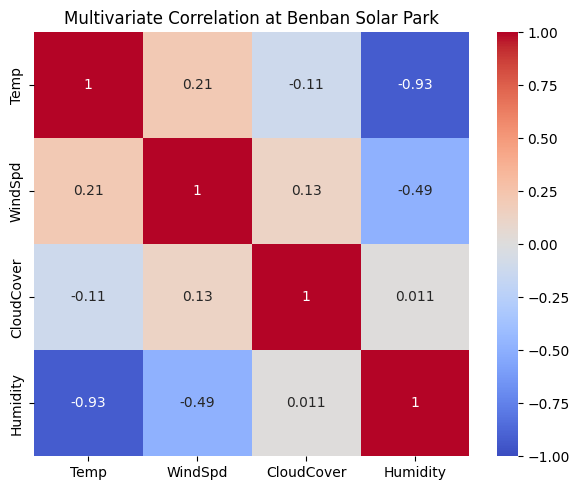


Correlation matrix for Bhadla Solar Park:
                temp  wind_speed        cc         q
temp        1.000000    0.242034  0.176088  0.126713
wind_speed  0.242034    1.000000  0.154383  0.325585
cc          0.176088    0.154383  1.000000  0.523411
q           0.126713    0.325585  0.523411  1.000000 



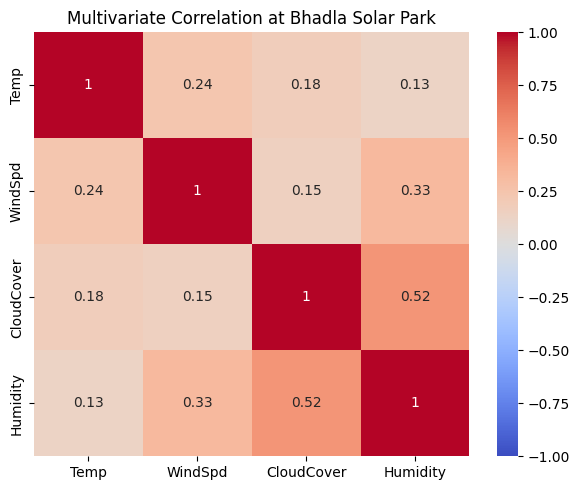


Correlation matrix for Cestas Solar Park:
                temp  wind_speed        cc         q
temp        1.000000   -0.483585  0.494502  0.488969
wind_speed -0.483585    1.000000  0.176792 -0.848279
cc          0.494502    0.176792  1.000000 -0.177673
q           0.488969   -0.848279 -0.177673  1.000000 



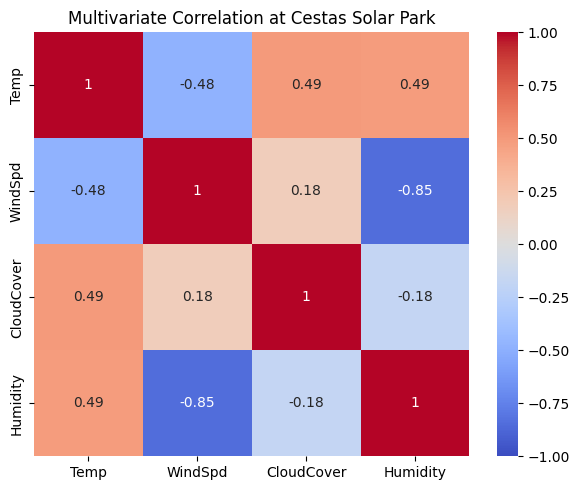


Correlation matrix for Desert Sunlight Solar Farm:
                temp  wind_speed        cc         q
temp        1.000000    0.736640  0.671744 -0.805754
wind_speed  0.736640    1.000000  0.562096 -0.544931
cc          0.671744    0.562096  1.000000 -0.699429
q          -0.805754   -0.544931 -0.699429  1.000000 



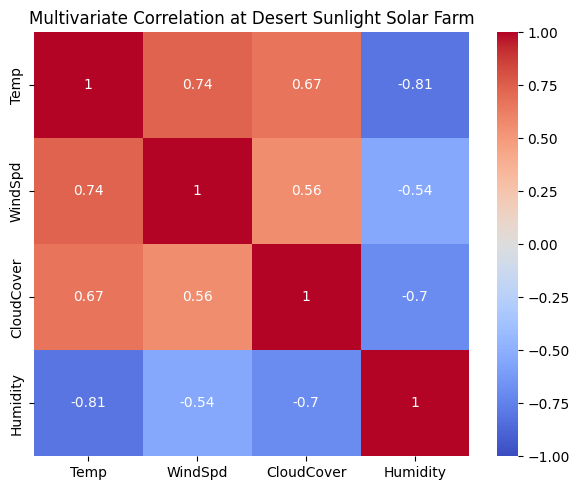


Correlation matrix for Núñez de Balboa Solar Plant:
                temp  wind_speed        cc         q
temp        1.000000   -0.544323 -0.245013  0.323991
wind_speed -0.544323    1.000000 -0.234000  0.482771
cc         -0.245013   -0.234000  1.000000 -0.280724
q           0.323991    0.482771 -0.280724  1.000000 



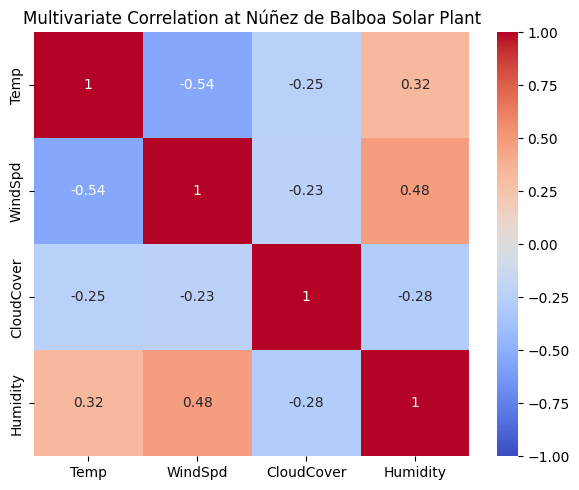


Correlation matrix for Tengger Desert Solar Park:
                temp  wind_speed        cc         q
temp        1.000000    0.772910  0.155705 -0.631089
wind_speed  0.772910    1.000000  0.118364 -0.735666
cc          0.155705    0.118364  1.000000  0.122844
q          -0.631089   -0.735666  0.122844  1.000000 



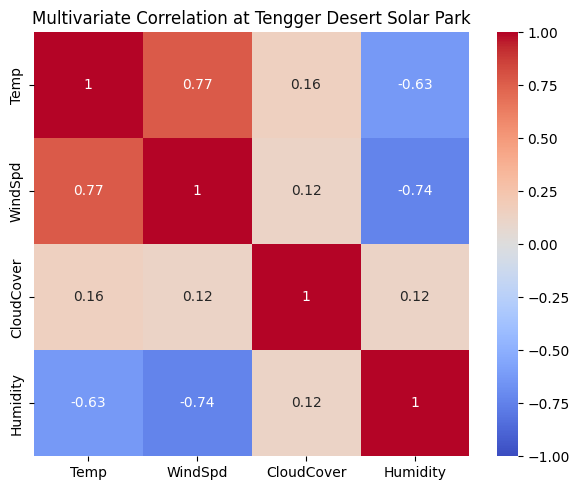


Correlation matrix for Topaz Solar Farm:
                temp  wind_speed        cc         q
temp        1.000000   -0.100423 -0.457442 -0.816348
wind_speed -0.100423    1.000000 -0.487996  0.082656
cc         -0.457442   -0.487996  1.000000  0.586886
q          -0.816348    0.082656  0.586886  1.000000 



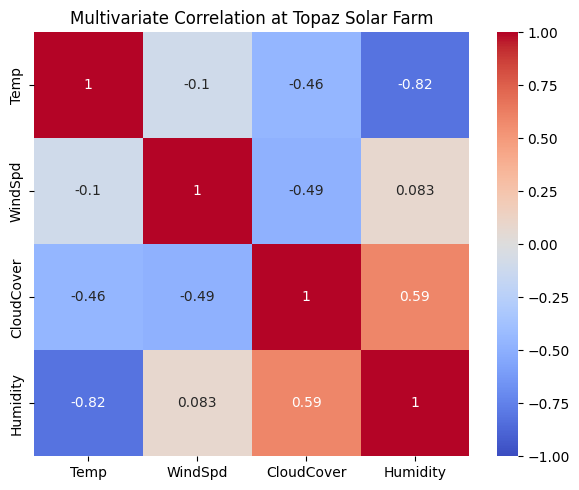

In [ ]:
# 1) Derive wind speed
master_df['wind_speed'] = np.hypot(master_df['u'], master_df['v'])

# 2) Define the four columns you want to correlate
vars_to_corr = ['temp', 'wind_speed', 'cc', 'q']
labels      = ['Temp', 'WindSpd', 'CloudCover', 'Humidity']

# 3) Loop over each field and compute + plot
for site, grp in master_df.groupby('field'):
    # compute Pearson correlation matrix
    corr_mat = grp[vars_to_corr].corr()

    print(f"\nCorrelation matrix for {site}:")
    print(corr_mat, "\n")

    # plot a heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(
        corr_mat,
        annot=True,
        cmap="coolwarm",
        vmin=-1, vmax=1,
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f"Multivariate Correlation at {site}")
    plt.tight_layout()
    plt.show()


### visualization

In [ ]:
# 1) Compute and stack correlations into long form
records = []
vars_to_corr = ['temp','wind_speed','cc','q']
for site, grp in master_df.groupby('field'):
    corr = grp[vars_to_corr].corr().stack()
    for (x,y), val in corr.items():
        if x < y:   # keep each pair only once
            records.append({'field': site,
                            'pair': f"{x}-{y}",
                            'corr': val})
df_long = pd.DataFrame(records)

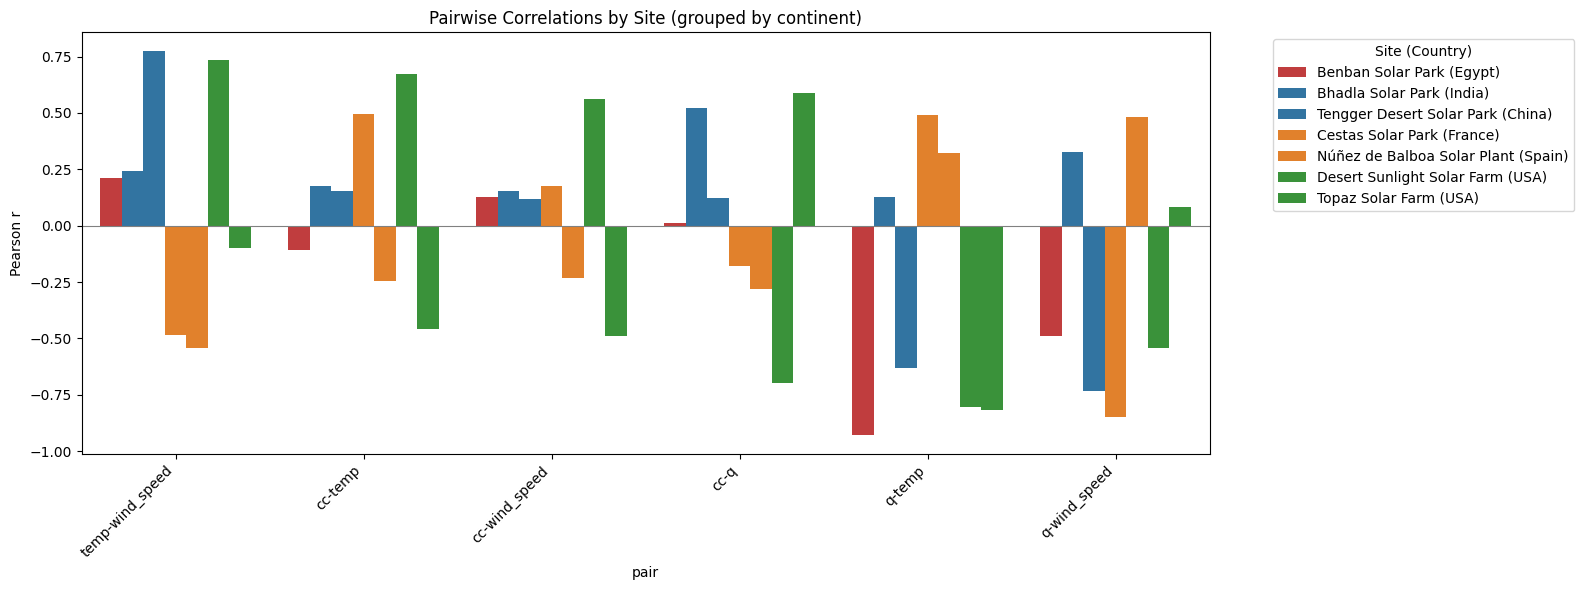

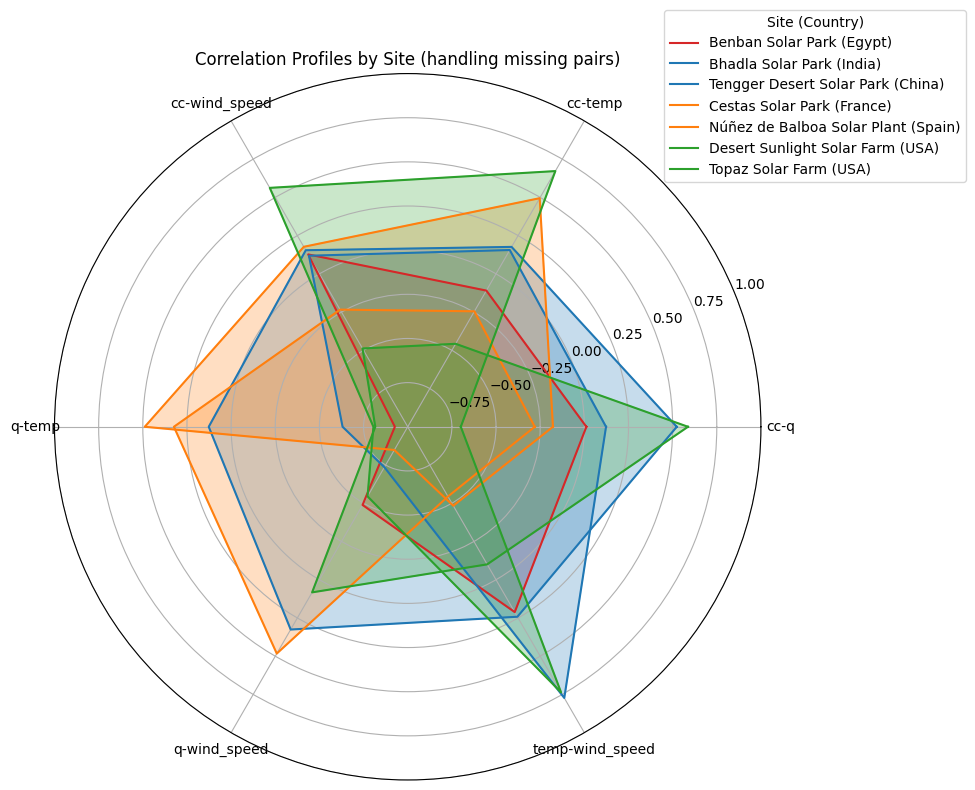

In [ ]:
continent_map = {
    "Bhadla Solar Park":            "Asia",
    "Tengger Desert Solar Park":    "Asia",
    "Topaz Solar Farm":             "North America",
    "Benban Solar Park":            "Africa",
    "Cestas Solar Park":            "Europe",
    "Núñez de Balboa Solar Plant":  "Europe",
    "Desert Sunlight Solar Farm":   "North America",
}
country_map = {
    "Bhadla Solar Park":            "India",
    "Tengger Desert Solar Park":    "China",
    "Topaz Solar Farm":             "USA",
    "Benban Solar Park":            "Egypt",
    "Cestas Solar Park":            "France",
    "Núñez de Balboa Solar Plant":  "Spain",
    "Desert Sunlight Solar Farm":   "USA",
}
continent_palette = {
    "Asia":          "#1f77b4",
    "Europe":        "#ff7f0e",
    "North America": "#2ca02c",
    "Africa":        "#d62728",
}

# 1) Build the combined “Site (Country)” label column and palette
df_long['site_country'] = df_long['field'] + " (" + df_long['field'].map(country_map) + ")"
site_country_palette = {
    f"{site} ({country_map[site]})": continent_palette[continent_map[site]]
    for site in continent_map
}

# 2) Decide the order: group by continent, then alphabetically
continent_order = ["Africa","Asia","Europe","North America"]
site_order = sorted(
    continent_map.keys(),
    key=lambda s: (continent_order.index(continent_map[s]), s)
)
hue_order = [f"{s} ({country_map[s]})" for s in site_order]

# 3) Plot with that hue_order
plt.figure(figsize=(16,6))
sns.barplot(
    data=df_long,
    x='pair',
    y='corr',
    hue='site_country',
    palette=site_country_palette,
    hue_order=hue_order,     # <— this is the key!
)
plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Pearson r")
plt.title("Pairwise Correlations by Site (grouped by continent)")
plt.legend(title="Site (Country)", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# Radar Chart
# prepare the angles & pairs
pairs  = sorted(df_long['pair'].unique())
angles = np.linspace(0, 2*np.pi, len(pairs), endpoint=False).tolist()
angles += angles[:1]   # close the loop

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))

for site in site_order:
    sub = df_long[df_long['field'] == site]
    # reindex to ensure every 'pair' is present, filling missing with NaN (or 0)
    corr_series = (
        sub.set_index('pair')['corr']
           .reindex(pairs, fill_value=np.nan)   # or fill_value=0
    )
    vals = corr_series.tolist()
    vals += [vals[0]]  # close the loop

    label = f"{site} ({country_map[site]})"
    color = site_country_palette[label]

    ax.plot(angles, vals, label=label, color=color)
    # for NaNs, fill will simply leave blanks
    ax.fill(angles, vals, color=color, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), pairs)
ax.set_ylim(-1,1)
ax.set_title("Correlation Profiles by Site (handling missing pairs)")
ax.legend(title="Site (Country)", loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.tight_layout()
plt.show()

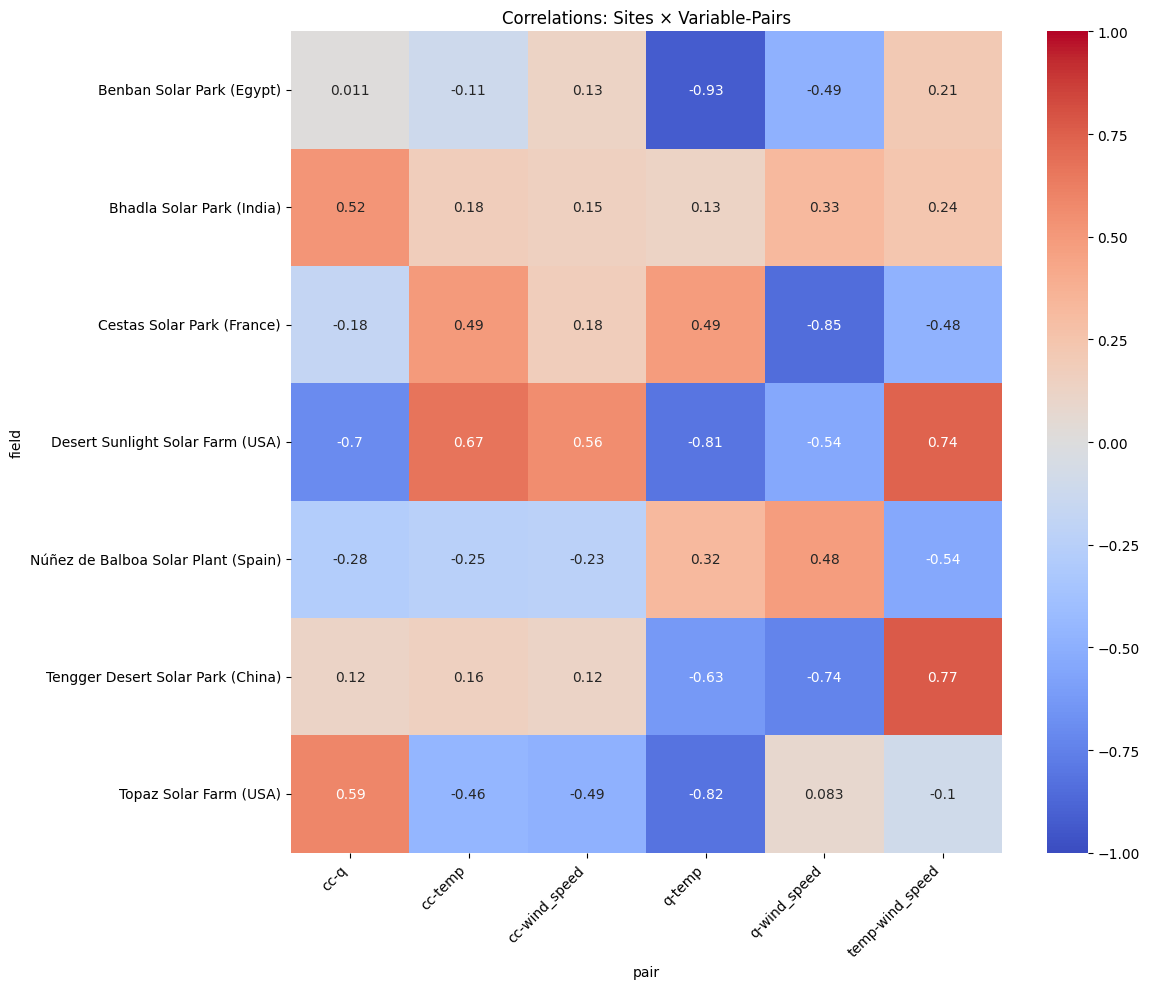

In [ ]:
pivot = df_long.pivot(index='field', columns='pair', values='corr')
pivot2 = pivot.rename(index=lambda site: f"{site} ({country_map[site]})")

plt.figure(figsize=(12,10))
ax = sns.heatmap(
    pivot2,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    yticklabels=True
)
# rotate y‐ticks and x‐ticks for clarity
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.title("Correlations: Sites × Variable-Pairs")
plt.tight_layout()
plt.show()

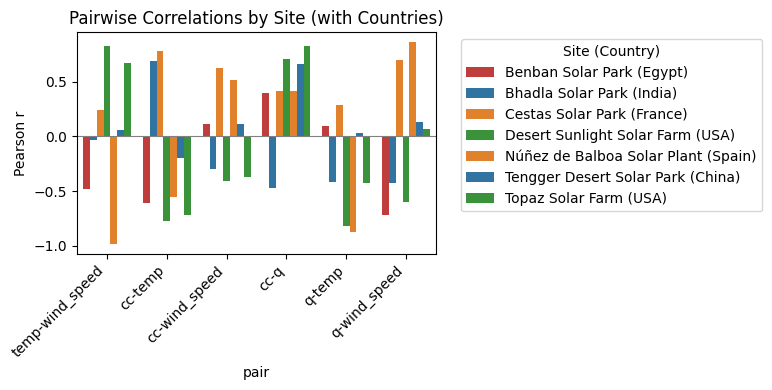

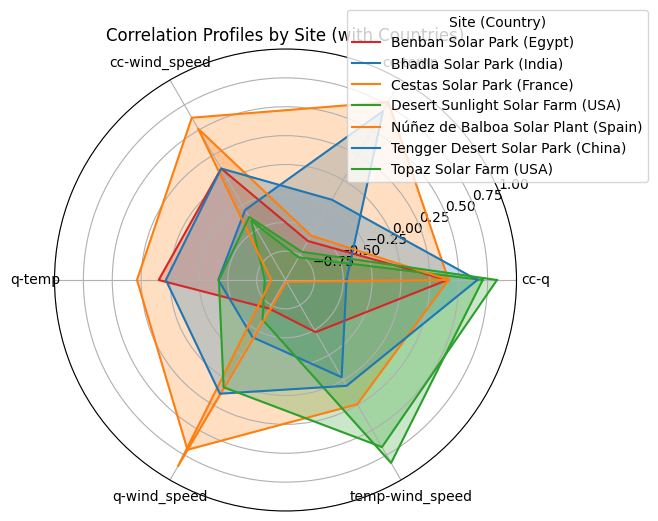

In [ ]:
# 1) Add a site→country mapping
country_map = {
    "Bhadla Solar Park":             "India",
    "Tengger Desert Solar Park":     "China",
    "Topaz Solar Farm":              "USA",
    "Benban Solar Park":             "Egypt",
    "Cestas Solar Park":             "France",
    "Núñez de Balboa Solar Plant":   "Spain",
    "Desert Sunlight Solar Farm":    "USA",
}

# 2) When you build df_long, add a new column for the combined label
df_long['site_country'] = df_long['field'] + " (" + df_long['field'].map(country_map) + ")"

# 3) Rebuild your palette to key off the new 'site_country'
site_country_palette = {
    f"{site} ({country_map[site]})": field_palette[site]
    for site in country_map
}

# ——— Bar Chart —————————————
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_long,
    x='pair',
    y='corr',
    hue='site_country',       # use combined label
    palette=site_country_palette
)
plt.axhline(0, color='gray', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Pearson r")
plt.title("Pairwise Correlations by Site (with Countries)")
plt.legend(title="Site (Country)", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# ——— Radar Chart ————————————
import numpy as np
pairs  = sorted(df_long['pair'].unique())
angles = np.linspace(0, 2*np.pi, len(pairs), endpoint=False).tolist() + [0]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
for site, sub in df_long.groupby('field'):
    label = f"{site} ({country_map[site]})"
    vals  = sub.set_index('pair').loc[pairs, 'corr'].tolist()
    vals += [vals[0]]  # close loop
    color = field_palette[site]
    ax.plot(angles, vals, label=label, color=color)
    ax.fill(angles, vals, color=color, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), pairs)
ax.set_ylim(-1,1)
ax.set_title("Correlation Profiles by Site (with Countries)")
ax.legend(title="Site (Country)", loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()

## Granger Test

In [ ]:
series_dict = {
    "Temperature": temp_series,
    "WindSpeed": wind_speed_series,
    "CloudCover": cc_series,
    "Humidity": q_series
}

# Assume data_pair is defined as a 2D numpy array:
# Column 0: Target variable (e.g., wind_speed_series)
# Column 1: Predictor variable (e.g., temp_series)
# For example, testing if Temperature Granger causes Wind Speed.
data_pair = np.column_stack((wind_speed_series, temp_series))
maxlag = 3

for lag in range(1, maxlag+1):
    print(f"\nGranger Causality Test for lag = {lag}")
    try:
        test_result = ts.grangercausalitytests(data_pair, maxlag=lag, verbose=True)
    except InfeasibleTestError as e:
        print(f"Skipping lag {lag} due to error: {e}")

variable_names = list(series_dict.keys())
maxlag = 3  # choose appropriate lag

for i in range(len(variable_names)):
  for j in range(len(variable_names)):
    if i != j:
      X = series_dict[variable_names[i]]
      Y = series_dict[variable_names[j]]
      # Test if X Granger causes Y
      data_pair = np.column_stack((Y, X))
      print(f"\nGranger Causality Test: Does {variable_names[i]} Granger Cause {variable_names[j]}?")
      # ts.grangercausalitytests(data_pair, maxlag=maxlag, verbose=True)
      try:
        test_result = ts.grangercausalitytests(data_pair, maxlag=lag, verbose=True)
      except InfeasibleTestError as e:
        print(f"Skipping lag {lag} due to error: {e}")


Granger Causality Test for lag = 1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2015  , p=0.0066  , df_denom=20, df_num=1
ssr based chi2 test:   chi2=10.5818 , p=0.0011  , df=1
likelihood ratio test: chi2=8.7052  , p=0.0032  , df=1
parameter F test:         F=9.2015  , p=0.0066  , df_denom=20, df_num=1

Granger Causality Test for lag = 2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2015  , p=0.0066  , df_denom=20, df_num=1
ssr based chi2 test:   chi2=10.5818 , p=0.0011  , df=1
likelihood ratio test: chi2=8.7052  , p=0.0032  , df=1
parameter F test:         F=9.2015  , p=0.0066  , df_denom=20, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1514  , p=0.0685  , df_denom=17, df_num=2
ssr based chi2 test:   chi2=8.1566  , p=0.0169  , df=2
likelihood ratio test: chi2=6.9380  , p=0.0311  , df=2
parameter F test:         F=3.1514  , p=0.0685  , df_denom=17, df_num=2

Granger Causality Test for 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
def extract_granger_pvalue(data_pair, lag):
    """
    Runs Granger causality test for a given lag and returns the p-value of the ssr based F-test.
    """
    try:
        test_results = ts.grangercausalitytests(data_pair, maxlag=lag, verbose=False)
        # Extract the p-value for the given lag from the ssr based F-test.
        p_value = test_results[lag][0]['ssr_ftest'][1]
    except InfeasibleTestError:
        p_value = np.nan
    return p_value

In [ ]:
variable_names = list(series_dict.keys())
maxlag = 3  # you can adjust the maximum lag
results_list = []

# Loop over all ordered pairs (predictor -> target)
for predictor in variable_names:
    for target in variable_names:
        if predictor != target:
            X = series_dict[predictor]
            Y = series_dict[target]
            # Create a data pair: column 0 is the target, column 1 is the predictor
            data_pair = np.column_stack((Y, X))
            for lag in range(1, maxlag+1):
                p_val = extract_granger_pvalue(data_pair, lag)
                results_list.append({
                    'Predictor': predictor,
                    'Target': target,
                    'Lag': lag,
                    'p_value': p_val
                })

# Create a DataFrame from the results
df_results = pd.DataFrame(results_list)
print(df_results)

      Predictor       Target  Lag   p_value
0   Temperature    WindSpeed    1  0.006563
1   Temperature    WindSpeed    2  0.068524
2   Temperature    WindSpeed    3  0.227769
3   Temperature   CloudCover    1  0.934732
4   Temperature   CloudCover    2  0.991964
5   Temperature   CloudCover    3  0.339901
6   Temperature     Humidity    1  0.111869
7   Temperature     Humidity    2  0.604581
8   Temperature     Humidity    3  0.528873
9     WindSpeed  Temperature    1  0.097154
10    WindSpeed  Temperature    2  0.297465
11    WindSpeed  Temperature    3  0.367870
12    WindSpeed   CloudCover    1  0.934750
13    WindSpeed   CloudCover    2  0.704699
14    WindSpeed   CloudCover    3  0.927576
15    WindSpeed     Humidity    1  0.076877
16    WindSpeed     Humidity    2  0.511600
17    WindSpeed     Humidity    3  0.565013
18   CloudCover  Temperature    1  0.745349
19   CloudCover  Temperature    2  0.028533
20   CloudCover  Temperature    3  0.087343
21   CloudCover    WindSpeed    

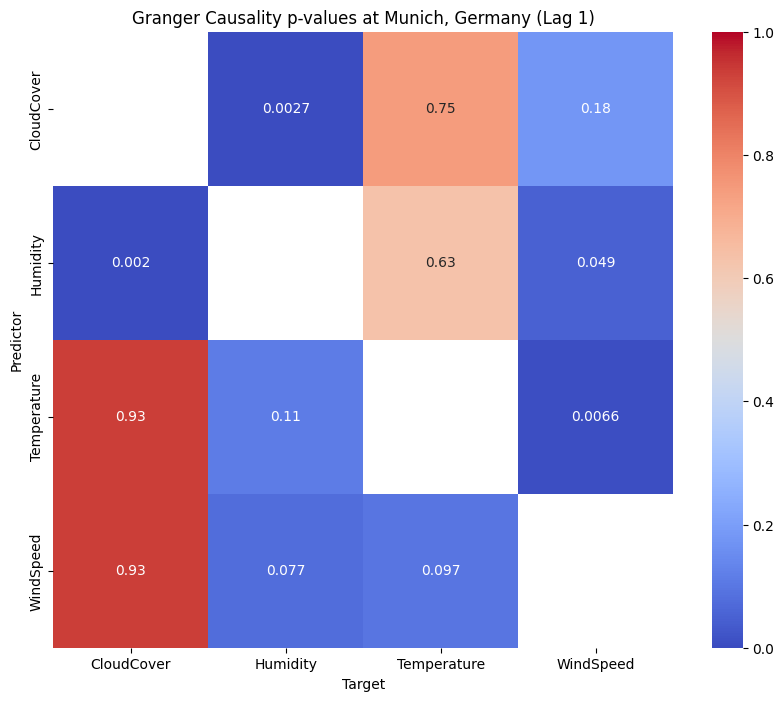

In [ ]:
# Filter results for lag 1
df_lag1 = df_results[df_results['Lag'] == 1]

# Pivot the DataFrame so that rows are predictors and columns are targets.
pivot_table = df_lag1.pivot(index='Predictor', columns='Target', values='p_value')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title(f"Granger Causality p-values at {location} (Lag 1)")
plt.show()

* better visulization on other lags (load data from a longer period?)

## Load Longer Period

In [ ]:
import subprocess
from datetime import datetime, timedelta

def download_era5_day(date_str,
                      pressure_level=500,
                      out_dir=".",
                      vars_pressure=None,
                      vars_single=None):
    """
    Download ERA5 variables for one calendar day from GCS.

    Parameters
    ----------
    date_str : str
        YYYY-MM-DD, e.g. "2023-07-30"
    pressure_level : int
        hPa level for pressure-level vars (default 500)
    out_dir : str
        directory to write the .nc files into
    vars_pressure : list of str
        names under date-variable-pressure_level
    vars_single : list of str
        names under date-variable-single_level
    """
    # defaults
    if vars_pressure is None:
        vars_pressure = [
            "specific_humidity",
            "temperature",
            "u_component_of_wind",
            "v_component_of_wind"
        ]
    if vars_single is None:
        vars_single = ["high_cloud_cover"]

    # parse and build paths
    date = datetime.strptime(date_str, "%Y-%m-%d")
    path = f"{date.year}/{date.month:02d}/{date.day:02d}"
    day_tag = date.strftime("%Y-%m-%d")

    # 1) single_level variables (surface.nc)
    for var in vars_single:
        src = (
            f"gs://gcp-public-data-arco-era5/raw/"
            f"date-variable-single_level/{path}/{var}/surface.nc"
        )
        dst = f"{out_dir}/{var}_{day_tag}.nc"
        print("Downloading", src)
        subprocess.run(["gsutil", "cp", src, dst], check=True)

    # 2) pressure_level variables (<level>.nc)
    for var in vars_pressure:
        src = (
            f"gs://gcp-public-data-arco-era5/raw/"
            f"date-variable-pressure_level/{path}/{var}/{pressure_level}.nc"
        )
        dst = f"{out_dir}/{var}_{pressure_level}hPa_{day_tag}.nc"
        print("Downloading", src)
        subprocess.run(["gsutil", "cp", src, dst], check=True)

# ── Usage examples ─────────────────────────────────────────────────────────
# Download everything for July 30, 2023:
# download_era5_day("2023-07-30")

# Loop over a week:
start = datetime(2024,1,1)
for i in range(7):
    day = (start + timedelta(days=i)).strftime("%Y-%m-%d")
    download_era5_day(day)

In [ ]:
import xarray as xr
import glob, os

# where you downloaded all of your .nc files
out_dir = "."

# 1) Build up globs for your single‐level and pressure‐level files
cc_files = sorted(glob.glob(os.path.join(out_dir, "high_cloud_cover_*.nc")))
q_files  = sorted(glob.glob(os.path.join(out_dir, "specific_humidity_500hPa_*.nc")))
t_files  = sorted(glob.glob(os.path.join(out_dir, "temperature_500hPa_*.nc")))
u_files  = sorted(glob.glob(os.path.join(out_dir, "u_component_of_wind_500hPa_*.nc")))
v_files  = sorted(glob.glob(os.path.join(out_dir, "v_component_of_wind_500hPa_*.nc")))

# 2) Open each variable across all days in one go
ds_cc = xr.open_mfdataset(cc_files, combine="by_coords")   # contains variable hcc
ds_q  = xr.open_mfdataset(q_files,  combine="by_coords")   # contains q
ds_t  = xr.open_mfdataset(t_files,  combine="by_coords")   # contains t
ds_u  = xr.open_mfdataset(u_files,  combine="by_coords")   # contains u
ds_v  = xr.open_mfdataset(v_files,  combine="by_coords")   # contains v

# 3) Merge them into a single Dataset, automatically aligned on time, lat, lon
ds = xr.merge([ds_cc, ds_q, ds_t, ds_u, ds_v])

print(ds)
# <xarray.Dataset>
# Dimensions:    (time: 168, latitude: 721, longitude: 1440)
# Coordinates:
#   * time       (time) datetime64[ns] 2023-07-25T00:00:00 ... 2023-07-31T23:00:00
#   * latitude   (latitude) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
#   * longitude  (longitude) float32 0.0 0.25 0.5 ... 359.0 359.25 359.5
# Data variables:
#     hcc        (time, latitude, longitude) float32  ...
#     q          (time, latitude, longitude) float32  ...
#     t          (time, latitude, longitude) float32  ...
#     u          (time, latitude, longitude) float32  ...
#     v          (time, latitude, longitude) float32  ...

# Now you have one Dataset “ds” spanning all 7 days.


<xarray.Dataset> Size: 14GB
Dimensions:    (time: 336, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 3kB 2023-07-25 ... 2024-01-07T23:00:00
Data variables:
    hcc        (time, latitude, longitude) float64 3GB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    q          (time, latitude, longitude) float64 3GB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    t          (time, latitude, longitude) float64 3GB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    u          (time, latitude, longitude) float64 3GB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
    v          (time, latitude, longitude) float64 3GB dask.array<chunksize=(24, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-12 21:22:19 GMT by grib_to_netcdf-2.25.

In [ ]:
def extract_site_timeseries(ds, lat, lon):
    sel = dict(latitude=lat, longitude=lon, method="nearest")
    da_t = ds["t"].sel(**sel)
    da_u = ds["u"].sel(**sel)
    da_v = ds["v"].sel(**sel)
    da_cc= ds["hcc"].sel(**sel)
    da_q = ds["q"].sel(**sel)

    df = xr.merge([
        da_t.rename("temp"),
        da_u.rename("u"),
        da_v.rename("v"),
        da_cc.rename("cc"),
        da_q.rename("q")
    ]).to_dataframe().reset_index()
    df["wind_speed"] = (df["u"]**2 + df["v"]**2)**0.5
    return df

# Example for one site:
site_df = extract_site_timeseries(
    ds,
    lat=27.5833,   # e.g. Bhadla
    lon=71.4333
)

In [ ]:
SOLAR_FIELDS = [
    {"name": "Bhadla Solar Park",            "lat": 27.5833,   "lon":  71.4333},   # Rajasthan, India
    {"name": "Tengger Desert Solar Park",    "lat": 37.3333,   "lon": 103.8558},   # Ningxia, China
    {"name": "Topaz Solar Farm",             "lat": 35.2426,   "lon": -120.0096},  # California, USA
    {"name": "Benban Solar Park",            "lat": 24.5561,   "lon":  32.9016},   # Aswan Governorate, Egypt
    # {"name": "Noor Ouarzazate Solar Complex","lat": 30.9070,   "lon":  -6.9075},  # Ouarzazate, Morocco
    {"name": "Cestas Solar Park",            "lat": 44.7255,   "lon":  -0.8157},  # Gironde, France
    {"name": "Núñez de Balboa Solar Plant",  "lat": 38.4533,   "lon":  -6.2260},  # Extremadura, Spain
    {"name": "Desert Sunlight Solar Farm",   "lat": 33.82139,  "lon": -115.39389},  # Riverside County, USA

    # new entries:
    {"name": "Pirapora Solar Complex",       "lat": -17.0891,  "lon": -44.9878},   # Minas Gerais, Brazil
    {"name": "Nyngan Solar Plant",           "lat": -31.5575,  "lon": 147.2031},    # New South Wales, Australia
]

all_dfs = []
for fld in SOLAR_FIELDS:
    df = extract_site_timeseries(ds, fld["lat"], fld["lon"])
    df["field"] = fld["name"]
    all_dfs.append(df)

master_df2 = pd.concat(all_dfs, ignore_index=True)
master_df2

,time,longitude,latitude,temp,u,v,cc,q,wind_speed,field
0,2023-07-25 00:00:00,71.50,27.5,272.215336,-2.342900,6.302002,0.983123,0.004054,6.723422,Bhadla Solar Park
1,2023-07-25 01:00:00,71.50,27.5,272.478150,-1.918238,5.907655,1.000000,0.004067,6.211282,Bhadla Solar Park
2,2023-07-25 02:00:00,71.50,27.5,272.603344,-1.600591,6.126462,0.966460,0.004131,6.332095,Bhadla Solar Park
3,2023-07-25 03:00:00,71.50,27.5,272.421764,-1.952211,6.119045,1.000000,0.004249,6.422915,Bhadla Solar Park
4,2023-07-25 04:00:00,71.50,27.5,272.225849,-2.249474,6.074542,1.000000,0.004365,6.477669,Bhadla Solar Park
...,...,...,...,...,...,...,...,...,...,...
3019,2024-01-07 19:00:00,147.25,-31.5,266.834592,6.861020,-10.278372,0.919094,0.004550,12.357934,Nyngan Solar Plant
3020,2024-01-07 20:00:00,147.25,-31.5,266.647979,8.065773,-9.676831,0.523461,0.004123,12.597529,Nyngan Solar Plant
3021,2024-01-07 21:00:00,147.25,-31.5,266.260148,8.705450,-8.650117,0.121343,0.002801,12.272301,Nyngan Solar Plant
3022,2024-01-07 22:00:00,147.25,-31.5,267.359542,8.057836,-6.558895,0.090916,0.001222,10.389795,Nyngan Solar Plant


In [ ]:
master_df2.to_csv("summer_winter.csv", index=False)


=== Benban Solar Park (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.26 -0.09 -0.19
wind_speed -0.26        1.00 -0.31 -0.25
cc         -0.09       -0.31  1.00 -0.27
q          -0.19       -0.25 -0.27  1.00


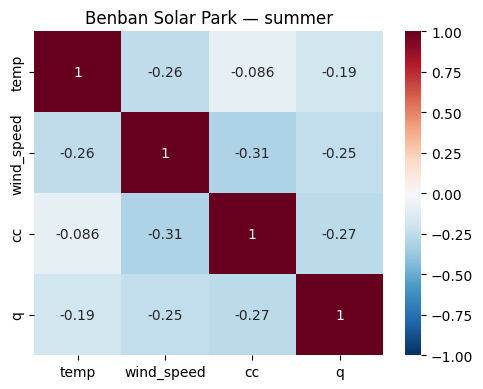


=== Benban Solar Park (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.07 -0.11 -0.45
wind_speed  0.07        1.00 -0.02  0.13
cc         -0.11       -0.02  1.00  0.02
q          -0.45        0.13  0.02  1.00


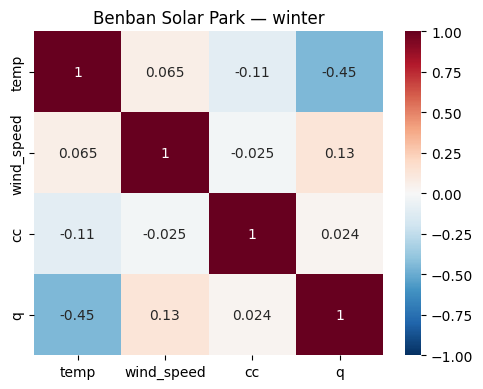


=== Bhadla Solar Park (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.15  0.70  0.42
wind_speed -0.15        1.00 -0.42 -0.38
cc          0.70       -0.42  1.00  0.75
q           0.42       -0.38  0.75  1.00


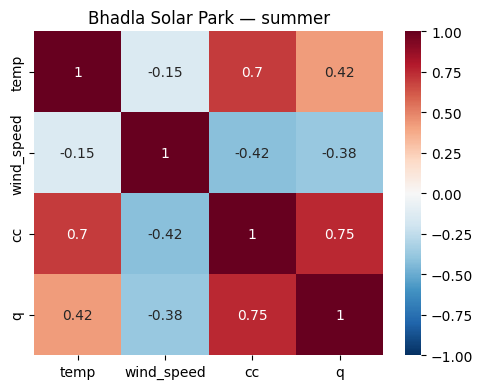


=== Bhadla Solar Park (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.09 -0.26 -0.81
wind_speed  0.09        1.00  0.14  0.15
cc         -0.26        0.14  1.00  0.26
q          -0.81        0.15  0.26  1.00


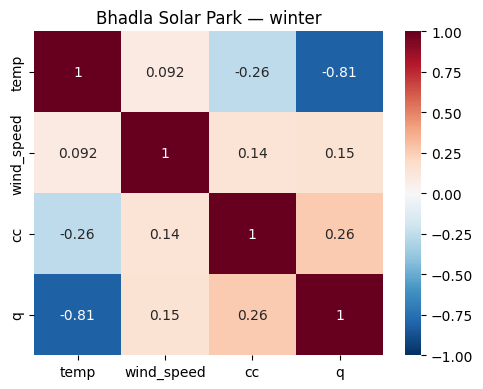


=== Cestas Solar Park (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.30 -0.21  0.15
wind_speed -0.30        1.00 -0.10  0.03
cc         -0.21       -0.10  1.00  0.02
q           0.15        0.03  0.02  1.00


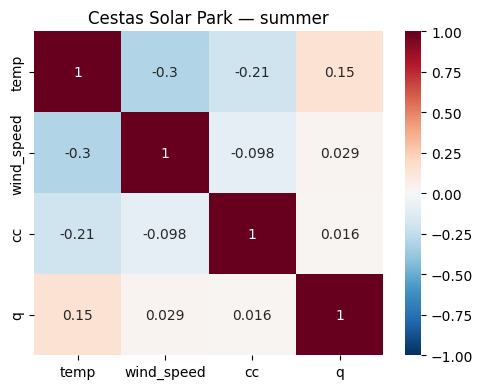


=== Cestas Solar Park (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.77  0.65  0.75
wind_speed  0.77        1.00  0.42  0.34
cc          0.65        0.42  1.00  0.58
q           0.75        0.34  0.58  1.00


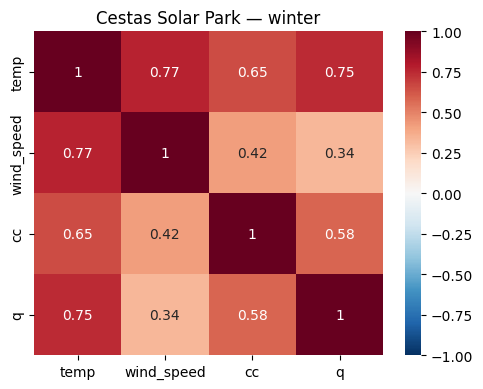


=== Desert Sunlight Solar Farm (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.05  0.17 -0.77
wind_speed  0.05        1.00  0.07 -0.15
cc          0.17        0.07  1.00  0.16
q          -0.77       -0.15  0.16  1.00


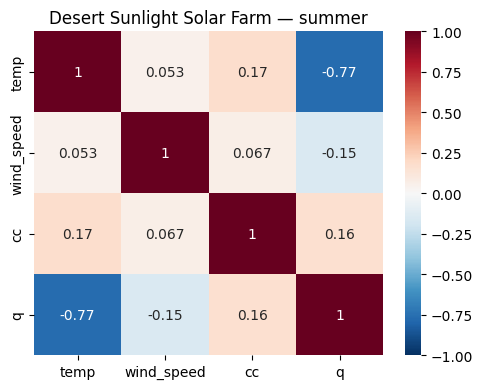


=== Desert Sunlight Solar Farm (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.50 -0.05  0.31
wind_speed -0.50        1.00  0.13 -0.36
cc         -0.05        0.13  1.00  0.51
q           0.31       -0.36  0.51  1.00


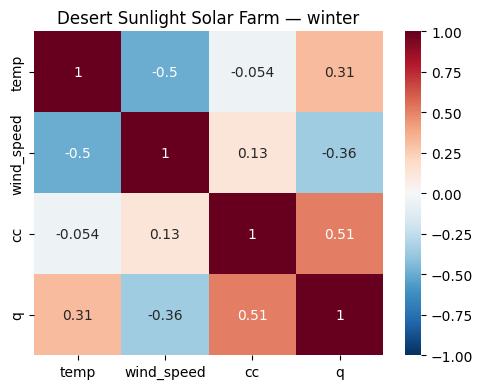


=== Nyngan Solar Plant (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.52 -0.25 -0.33
wind_speed  0.52        1.00  0.07  0.16
cc         -0.25        0.07  1.00  0.69
q          -0.33        0.16  0.69  1.00


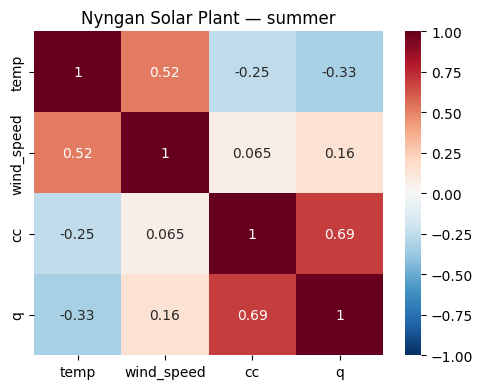


=== Nyngan Solar Plant (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.53  0.29  0.53
wind_speed  0.53        1.00  0.00  0.41
cc          0.29        0.00  1.00  0.49
q           0.53        0.41  0.49  1.00


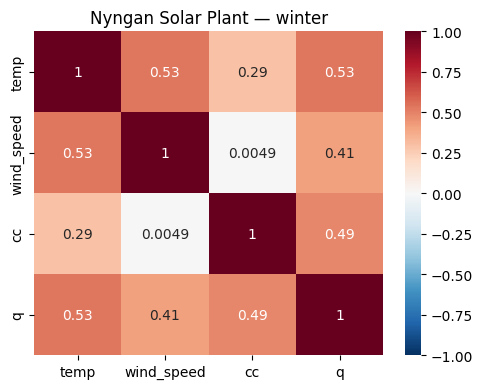


=== Núñez de Balboa Solar Plant (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.59 -0.22 -0.58
wind_speed -0.59        1.00  0.04  0.45
cc         -0.22        0.04  1.00  0.20
q          -0.58        0.45  0.20  1.00


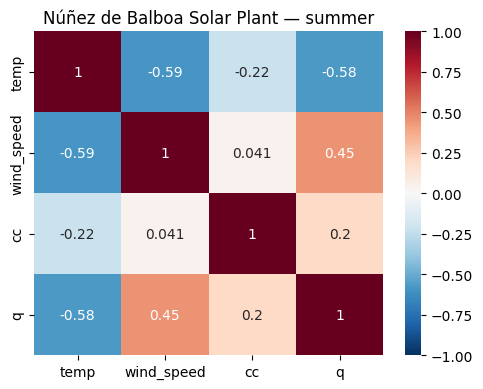


=== Núñez de Balboa Solar Plant (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.02  0.36  0.56
wind_speed -0.02        1.00 -0.43 -0.56
cc          0.36       -0.43  1.00  0.42
q           0.56       -0.56  0.42  1.00


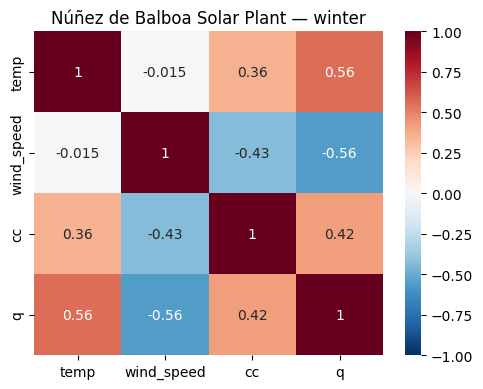


=== Pirapora Solar Complex (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.47  0.26  0.61
wind_speed  0.47        1.00  0.03  0.38
cc          0.26        0.03  1.00  0.28
q           0.61        0.38  0.28  1.00


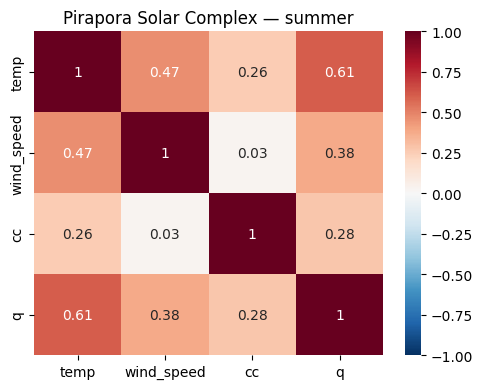


=== Pirapora Solar Complex (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.14 -0.25  0.53
wind_speed -0.14        1.00  0.02  0.02
cc         -0.25        0.02  1.00 -0.09
q           0.53        0.02 -0.09  1.00


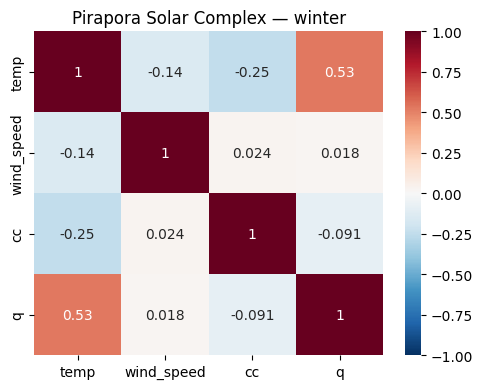


=== Tengger Desert Solar Park (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00        0.35 -0.66 -0.67
wind_speed  0.35        1.00 -0.27 -0.28
cc         -0.66       -0.27  1.00  0.61
q          -0.67       -0.28  0.61  1.00


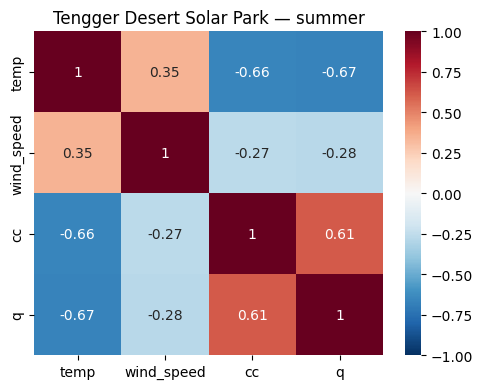


=== Tengger Desert Solar Park (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.26  0.11  0.10
wind_speed -0.26        1.00  0.01 -0.24
cc          0.11        0.01  1.00  0.13
q           0.10       -0.24  0.13  1.00


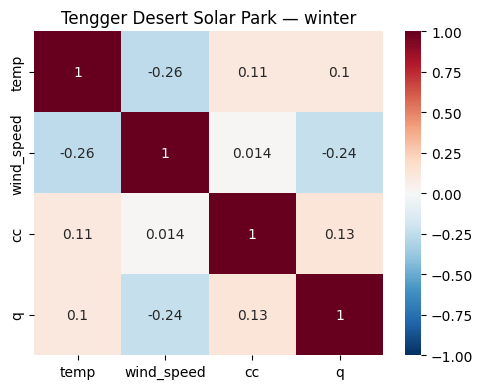


=== Topaz Solar Farm (summer) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.09 -0.32 -0.89
wind_speed -0.09        1.00  0.04 -0.10
cc         -0.32        0.04  1.00  0.38
q          -0.89       -0.10  0.38  1.00


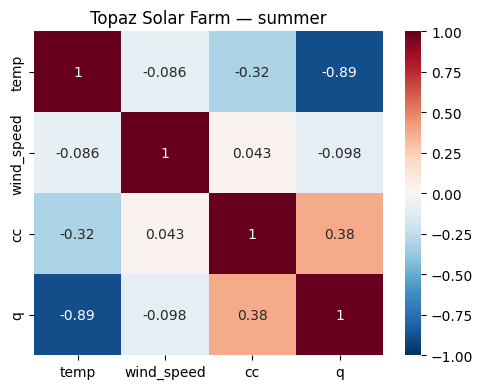


=== Topaz Solar Farm (winter) correlation ===
            temp  wind_speed    cc     q
temp        1.00       -0.53 -0.16  0.31
wind_speed -0.53        1.00  0.08 -0.33
cc         -0.16        0.08  1.00  0.53
q           0.31       -0.33  0.53  1.00


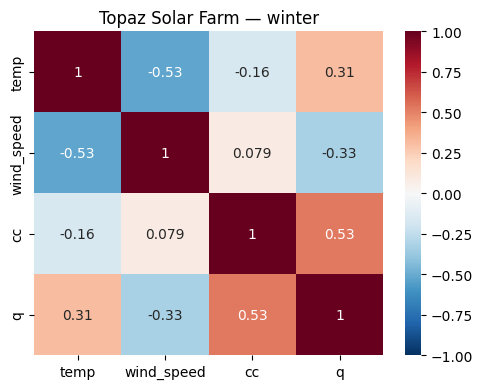


=== Granger Causality @ Benban Solar Park (summer) ===
lag : p‐value
   1 : 0.8498 
   2 : 0.7895 
   3 : 0.8856 
   4 : 0.9082 
   5 : 0.9200 
   6 : 0.8488 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Benban Solar Park (winter) ===
lag : p‐value
   1 : 0.8784 
   2 : 0.6842 
   3 : 0.7220 
   4 : 0.8500 
   5 : 0.9295 
   6 : 0.9700 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Bhadla Solar Park (summer) ===
lag : p‐value
   1 : 0.7134 
   2 : 0.8651 
   3 : 0.2177 
   4 : 0.3886 
   5 : 0.4039 
   6 : 0.3923 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Bhadla Solar Park (winter) ===
lag : p‐value
   1 : 0.1797 
   2 : 0.3942 
   3 : 0.2583 
   4 : 0.0691 
   5 : 0.0797 
   6 : 0.0636 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Cestas Solar Park (summer) ===
lag : p‐value
   1 : 0.6803 
   2 : 0.7630 
   3 : 0.3990 
   4 : 0.5089 
   5 : 0.6538 
   6 : 0.7015 


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

lag : p‐value
   1 : 0.0918 
   2 : 0.1632 
   3 : 0.2377 
   4 : 0.2391 
   5 : 0.3311 
   6 : 0.1808 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Pirapora Solar Complex (summer) ===
lag : p‐value
   1 : 0.9824 
   2 : 0.7398 
   3 : 0.8209 
   4 : 0.8781 
   5 : 0.8996 
   6 : 0.8999 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Pirapora Solar Complex (winter) ===
lag : p‐value
   1 : 0.4973 
   2 : 0.1689 
   3 : 0.0013 *
   4 : 0.0167 *
   5 : 0.0323 *
   6 : 0.0586 
 → wind_speed Granger‐causes cc at lags [3, 4, 5]

=== Granger Causality @ Tengger Desert Solar Park (summer) ===
lag : p‐value
   1 : 0.0910 
   2 : 0.1049 
   3 : 0.2032 
   4 : 0.3313 
   5 : 0.3860 
   6 : 0.4096 
 → no significant causality at p<0.05 up to lag 6

=== Granger Causality @ Tengger Desert Solar Park (winter) ===
lag : p‐value
   1 : 0.4643 
   2 : 0.4318 
   3 : 0.7921 
   4 : 0.8801 
   5 : 0.4970 
   6 : 0.4696 
 → no significant causality

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# 1) load & tag season
df = pd.read_csv("summer_winter.csv", parse_dates=["time"])
# label summer = Jul, winter = Jan
df["season"] = df["time"].dt.month.map(lambda m: "summer" if m==7 else ("winter" if m==1 else "other"))
df = df[df["season"].isin(["summer","winter"])]

# 2) correlation & heatmaps
for (field, season), g in df.groupby(["field","season"]):
    sub = (
        g.set_index("time")[["temp","wind_speed","cc","q"]]
         .sort_index()
    )
    corr = sub.corr()
    print(f"\n=== {field} ({season}) correlation ===")
    print(corr.round(2))
    plt.figure(figsize=(5,4))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="RdBu_r")
    plt.title(f"{field} — {season}")
    plt.tight_layout()
    plt.show()

# 3) Granger tests: wind_speed → cc
maxlag = 6
for (field, season), g in df.groupby(["field","season"]):
    data = (
        g.set_index("time")[["cc","wind_speed"]]
         .dropna()
         .sort_index()
    )
    print(f"\n=== Granger Causality @ {field} ({season}) ===")
    res = grangercausalitytests(data[["cc","wind_speed"]], maxlag=maxlag, verbose=False)
    # collect p‐values for ssr_chi2test
    pvals = {lag: res[lag][0]["ssr_chi2test"][1] for lag in range(1, maxlag+1)}
    print("lag : p‐value")
    for lag, p in pvals.items():
        star = "*" if p<0.05 else ""
        print(f"  {lag:>2} : {p:.4f} {star}")
    sig = [lag for lag,p in pvals.items() if p<0.05]
    if sig:
        print(f" → wind_speed Granger‐causes cc at lags {sig}")
    else:
        print(" → no significant causality at p<0.05 up to lag 6")

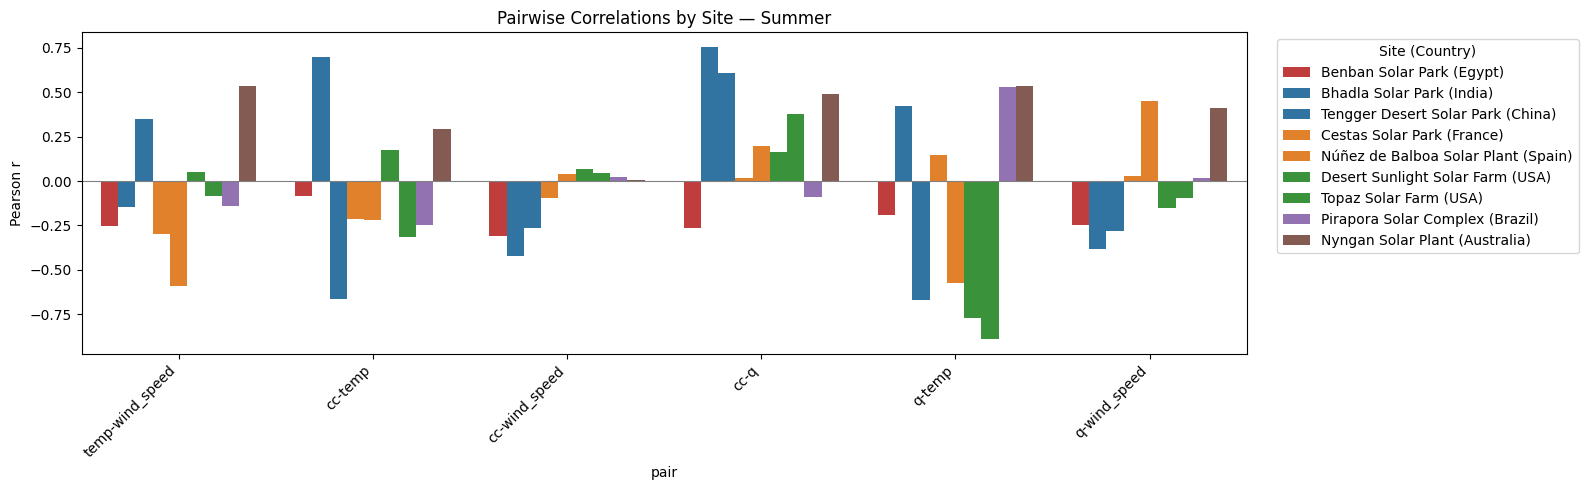

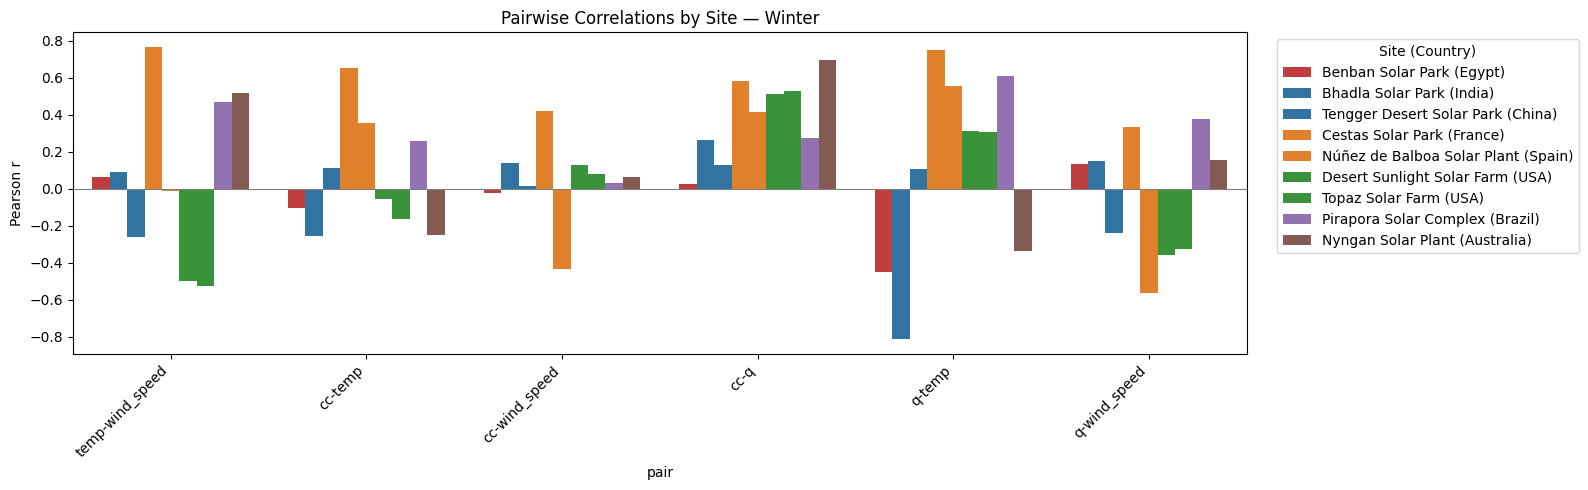

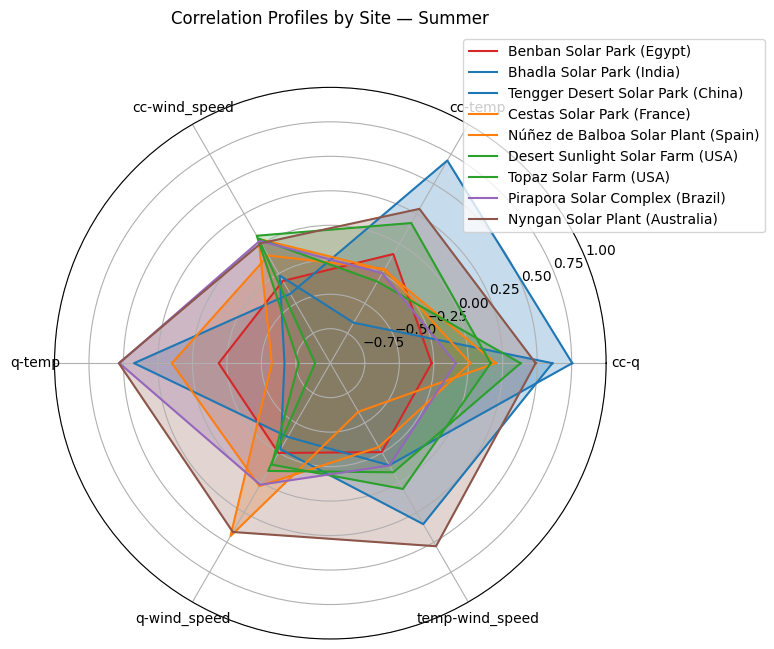

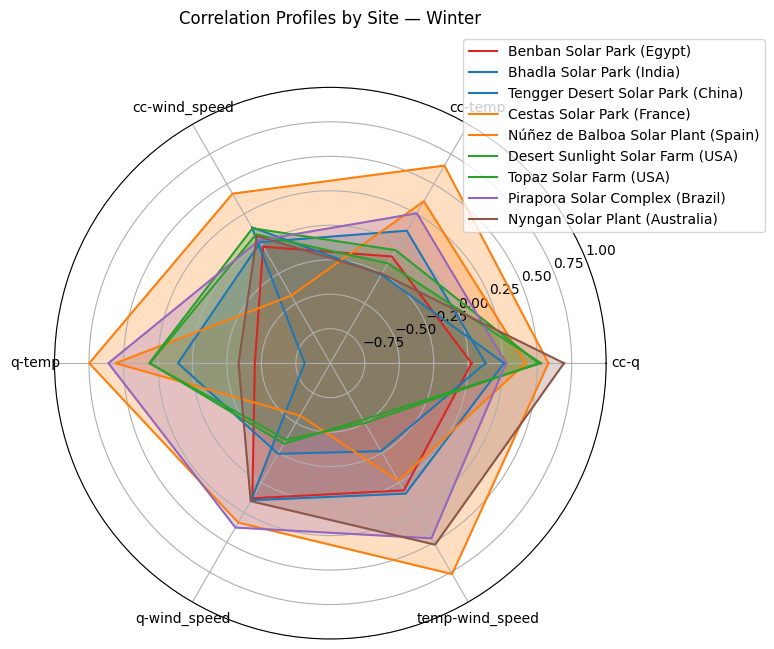

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns

# ── 1) load & hemisphere‐aware season tagging ───────────────────────────────
df = pd.read_csv("summer_winter.csv", parse_dates=["time"])
m = df["time"].dt.month
north = df["latitude"] >= 0
south = ~north
df["season"] = None
df.loc[north & (m == 7),  "season"] = "summer"
df.loc[north & (m == 1),  "season"] = "winter"
df.loc[south & (m == 7),  "season"] = "winter"
df.loc[south & (m == 1),  "season"] = "summer"
df = df[df["season"].isin(["summer","winter"])]

# ── 1) maps & palette (same as your original) ───────────────────────────────
continent_map = {
    "Bhadla Solar Park":            "Asia",
    "Tengger Desert Solar Park":    "Asia",
    "Topaz Solar Farm":             "North America",
    "Benban Solar Park":            "Africa",
    "Cestas Solar Park":            "Europe",
    "Núñez de Balboa Solar Plant":  "Europe",
    "Desert Sunlight Solar Farm":   "North America",
    "Pirapora Solar Complex":       "South America",
    "Nyngan Solar Plant":           "Australia",
}
country_map = {
    **{k:v for k,v in zip(
        ["Bhadla Solar Park","Tengger Desert Solar Park"],
        ["India","China"]
    )},
    "Topaz Solar Farm":            "USA",
    "Benban Solar Park":           "Egypt",
    "Cestas Solar Park":           "France",
    "Núñez de Balboa Solar Plant": "Spain",
    "Desert Sunlight Solar Farm":  "USA",
    "Pirapora Solar Complex":      "Brazil",
    "Nyngan Solar Plant":          "Australia",
}
continent_palette = {
    "Asia":          "#1f77b4",
    "Europe":        "#ff7f0e",
    "North America": "#2ca02c",
    "Africa":        "#d62728",
    "South America":"#9467bd",
    "Australia":    "#8c564b"
}
site_country_palette = {
    f"{site} ({country_map[site]})": continent_palette[continent_map[site]]
    for site in continent_map
}

# keep the ordering by continent → name
continent_order = ["Africa","Asia","Europe","North America","South America","Australia"]
site_order = sorted(
    continent_map.keys(),
    key=lambda s: (continent_order.index(continent_map[s]), s)
)
hue_order = [f"{s} ({country_map[s]})" for s in site_order]

# ── 2) load your summer_winter.csv & recompute long‐form correlations ───────
# df = pd.read_csv("summer_winter.csv", parse_dates=["time"])
# assume df already has `season` column from previous step
vars_to_corr = ['temp','wind_speed','cc','q']

records = []
for (site, season), grp in df.groupby(['field','season']):
    corr = grp[vars_to_corr].corr().stack()
    for (x,y), val in corr.items():
        if x < y:
            records.append({
                'field':  site,
                'season': season,
                'pair':   f"{x}-{y}",
                'corr':   val
            })

df_long = pd.DataFrame(records)
# add the “site_country” label for hue
df_long['site_country'] = df_long['field'].map(
    lambda s: f"{s} ({country_map[s]})"
)

pairs = sorted(df_long['pair'].unique())

# ── 3) one BAR CHART per season ──────────────────────────────────────────────
for season in ['summer','winter']:
    plt.figure(figsize=(16,5))
    sns.barplot(
        data=df_long[df_long['season']==season],
        x='pair', y='corr',
        hue='site_country',
        palette=site_country_palette,
        hue_order=hue_order
    )
    plt.axhline(0, color='gray', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Pearson r")
    plt.title(f"Pairwise Correlations by Site — {season.capitalize()}")
    plt.legend(title="Site (Country)", bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ── 4) one RADAR CHART per season ────────────────────────────────────────────
labels = pairs
N = len(labels)
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

for season in ['summer','winter']:
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)
    df_seas = df_long[df_long['season']==season]
    for site in site_order:
        sub = df_seas[df_seas['field']==site].set_index('pair')['corr']
        vals = sub.reindex(labels, fill_value=np.nan).tolist()
        vals += [vals[0]]
        label = f"{site} ({country_map[site]})"
        color = site_country_palette[label]
        ax.plot(angles, vals, label=label, color=color)
        ax.fill(angles, vals, alpha=0.25, color=color)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylim(-1, 1)
    ax.set_title(f"Correlation Profiles by Site — {season.capitalize()}", y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

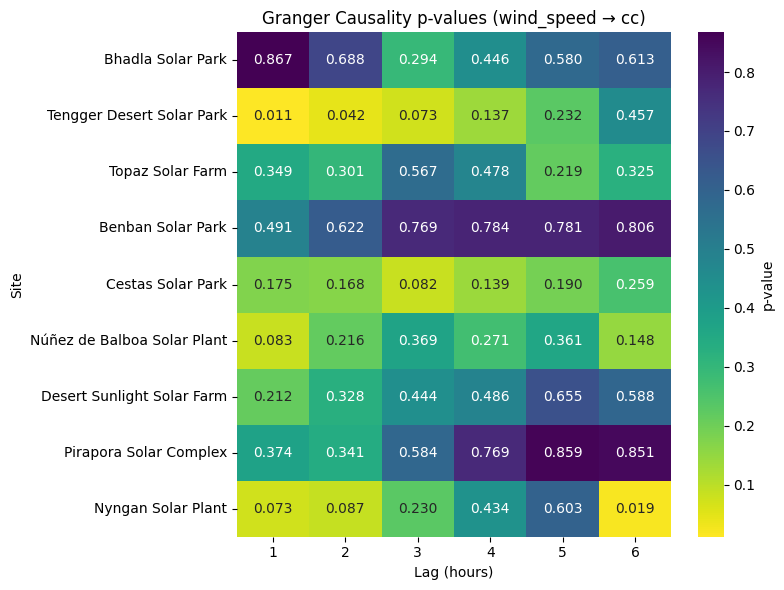

In [ ]:
# ── 1) load & hemisphere‐aware season tagging ───────────────────────────────
import pandas as pd
df = pd.read_csv("summer_winter.csv", parse_dates=["time"])
m = df["time"].dt.month
north = df["latitude"] >= 0
south = ~north
df["season"] = None
df.loc[north & (m == 7),  "season"] = "summer"
df.loc[north & (m == 1),  "season"] = "winter"
df.loc[south & (m == 7),  "season"] = "winter"
df.loc[south & (m == 1),  "season"] = "summer"
df = df[df["season"].isin(["summer","winter"])]

# ── compute Granger p‐values ────────────────────────────────────────────────
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

sites = df["field"].unique()
lags  = range(1,7)
pvals = pd.DataFrame(index=sites, columns=lags, dtype=float)

for site in sites:
    sub = df[df["field"]==site].set_index("time")[["cc","wind_speed"]].dropna()
    res = grangercausalitytests(sub[["cc","wind_speed"]], maxlag=6, verbose=False)
    for lag in lags:
        pvals.loc[site, lag] = res[lag][0]["ssr_chi2test"][1]

# ── plot heatmap ────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    pvals,
    annot=True, fmt=".3f",
    cmap="viridis_r",
    cbar_kws={'label':'p-value'}
)
plt.axhline(-0.5, color='white', linewidth=2)  # optional
plt.title("Granger Causality p-values (wind_speed → cc)")
plt.xlabel("Lag (hours)")
plt.ylabel("Site")
plt.tight_layout()
plt.show()


In [ ]:
# e.g. to test q → cc:
from statsmodels.tsa.stattools import grangercausalitytests

for site, g in df.groupby('field'):
    data = g.set_index('time')[['cc','q']].dropna()
    print(f"\nGranger: q → cc at {site}")
    grangercausalitytests(data[['cc','q']], maxlag=6, verbose=True)

# and similarly for cc → temp:
for site, g in df.groupby('field'):
    data = g.set_index('time')[['temp','cc']].dropna()
    print(f"\nGranger: cc → temp at {site}")
    grangercausalitytests(data[['temp','cc']], maxlag=6, verbose=True)


Granger: q → cc at Benban Solar Park

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0231  , p=0.8792  , df_denom=332, df_num=1
ssr based chi2 test:   chi2=0.0233  , p=0.8786  , df=1
likelihood ratio test: chi2=0.0233  , p=0.8786  , df=1
parameter F test:         F=0.0231  , p=0.8792  , df_denom=332, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0399  , p=0.9609  , df_denom=329, df_num=2
ssr based chi2 test:   chi2=0.0809  , p=0.9603  , df=2
likelihood ratio test: chi2=0.0809  , p=0.9604  , df=2
parameter F test:         F=0.0399  , p=0.9609  , df_denom=329, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0353  , p=0.9911  , df_denom=326, df_num=3
ssr based chi2 test:   chi2=0.1083  , p=0.9908  , df=3
likelihood ratio test: chi2=0.1083  , p=0.9908  , df=3
parameter F test:         F=0.0353  , p=0.9911  , df_denom=326, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

likelihood ratio test: chi2=0.3063  , p=0.9975  , df=5
parameter F test:         F=0.0593  , p=0.9977  , df_denom=320, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.0536  , p=0.9994  , df_denom=317, df_num=6
ssr based chi2 test:   chi2=0.3348  , p=0.9993  , df=6
likelihood ratio test: chi2=0.3346  , p=0.9993  , df=6
parameter F test:         F=0.0536  , p=0.9994  , df_denom=317, df_num=6

Granger: cc → temp at Bhadla Solar Park

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8502  , p=0.0923  , df_denom=332, df_num=1
ssr based chi2 test:   chi2=2.8760  , p=0.0899  , df=1
likelihood ratio test: chi2=2.8637  , p=0.0906  , df=1
parameter F test:         F=2.8502  , p=0.0923  , df_denom=332, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5265  , p=0.2188  , df_denom=329, df_num=2
ssr based chi2 test:   chi2=3.0993  , p=0.2123  , df=2
likelihood ratio test: chi2=3.0850  , p=0.2138  , df=

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

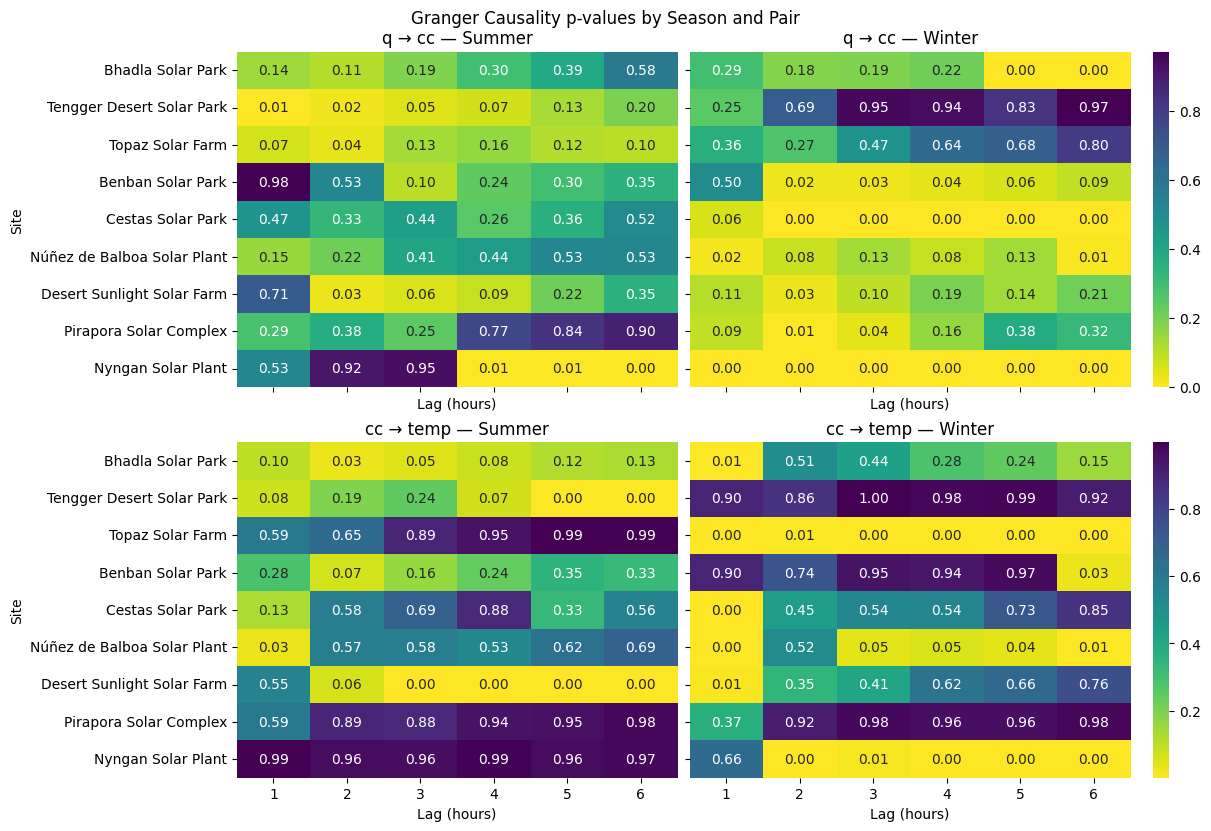

In [ ]:
# ── 1) load & hemisphere‐aware season tagging ───────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

df = pd.read_csv("summer_winter.csv", parse_dates=["time"])
m = df["time"].dt.month
north = df["latitude"] >= 0
south = ~north
df["season"] = None
df.loc[north & (m == 7),  "season"] = "summer"
df.loc[north & (m == 1),  "season"] = "winter"
df.loc[south & (m == 7),  "season"] = "winter"
df.loc[south & (m == 1),  "season"] = "summer"
df = df[df["season"].isin(["summer","winter"])]

# ── 2) compute Granger p-values for q→cc and cc→temp ────────────────────────
pairs   = [("q", "cc"), ("cc", "temp")]   # (predictor, target)
sites   = df["field"].unique()
seasons = ["summer", "winter"]
lags    = range(1, 7)

# initialize nested dict of DataFrames
pvals = {
    (x, y): {
        season: pd.DataFrame(index=sites, columns=lags, dtype=float)
        for season in seasons
    }
    for x, y in pairs
}

for x, y in pairs:
    for season in seasons:
        sub_season = df[df["season"] == season]
        for site in sites:
            sub = (
                sub_season[sub_season["field"] == site]
                .set_index("time")[[y, x]]
                .dropna()
            )
            if len(sub) < max(lags) + 1:
                continue
            res = grangercausalitytests(sub[[y, x]], maxlag=max(lags), verbose=False)
            for lag in lags:
                p = res[lag][0]["ssr_chi2test"][1]
                pvals[(x, y)][season].loc[site, lag] = p

# ── 3) plot a 2×2 grid of heatmaps with equal widths ───────────────────────
fig, axes = plt.subplots(
    len(pairs), len(seasons),
    figsize=(12, 8),
    sharex=True, sharey=False,  # Changed sharey to False
    gridspec_kw={'width_ratios': [1, 1]},
    constrained_layout=True
)

for i, (x, y) in enumerate(pairs):
    for j, season in enumerate(seasons):
        ax = axes[i, j]
        df_heat = pvals[(x, y)][season]
        sns.heatmap(
            df_heat,
            annot=True, fmt=".2f",
            cmap="viridis_r",
            cbar=(j == len(seasons) - 1),
            ax=ax
        )
        ax.set_title(f"{x} → {y} — {season.capitalize()}")
        ax.set_xlabel("Lag (hours)")
        if j == 0:
            ax.set_ylabel("Site")
        else:
            # Remove y-tick labels for the winter column
            ax.set_ylabel("")
            ax.set_yticklabels([])

plt.suptitle("Granger Causality p-values by Season and Pair", y=1.02)
plt.show()

# Direct Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
temporal_path = "/content/drive/MyDrive/CERA_Rika+Hongjin/utils+data/era5_bhadla_2201-2202.csv"

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np

# same as benchmark
# load the saved feature file
df = pd.read_csv(temporal_path, parse_dates=["valid_time"])

# extract one site
site_name = "Bhadla"
df_site = df[df["site"] == site_name].copy()
df_site = df_site.sort_values("valid_time")

# convert accumulated ssrd (J/m²) to irradiance (W/m²)
df_site["ssrd_irradiance"] = df_site["ssrd"].diff() / 3600.0  # Assuming hourly
df_site["ssrd_irradiance"] = df_site["ssrd_irradiance"].clip(lower=0)
df_site = df_site.dropna(subset=["ssrd_irradiance"])  # Drop first NaN

# create the target as next-24hr irradiance (t+24)
df_site["target"] = df_site["ssrd_irradiance"].shift(-24)
df_site = df_site.dropna(subset=["target"]) # drop NaNs (the last 24 rows won’t have valid targets)

# filter where next-hour irradiance (target) is greater than 0
df_site = df_site[df_site["target"] > 0]

# add temporal features
df_site["hour"] = df_site["valid_time"].dt.hour
df_site["dayofyear"] = df_site["valid_time"].dt.dayofyear

df_site

Index(['valid_time', 'ssrd', 'number_x', 'latitude_x', 'longitude_x',
       'expver_x', 'site', 'q', 't', 'cc', 'u', 'v', 'number_y',
       'pressure_level', 'latitude_y', 'longitude_y', 'expver_y',
       'ssrd_irradiance', 'target', 'hour', 'dayofyear'],
      dtype='object')

## Temporal

### ACF/PACF

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

/tmp/ipython-input-228922714.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()


<Figure size 1200x500 with 0 Axes>

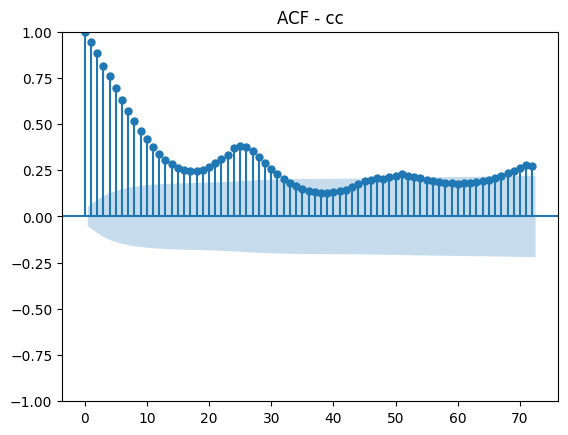

<Figure size 1200x500 with 0 Axes>

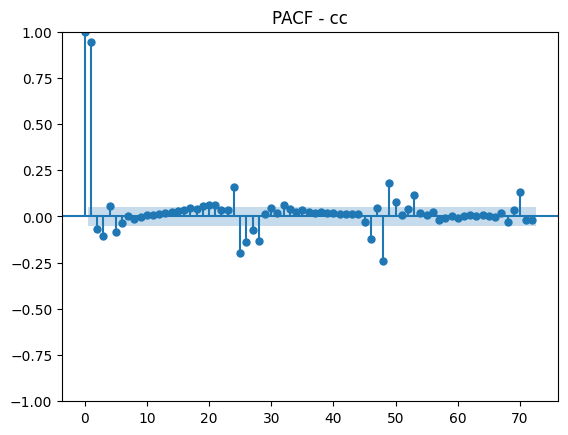

/tmp/ipython-input-228922714.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()


<Figure size 1200x500 with 0 Axes>

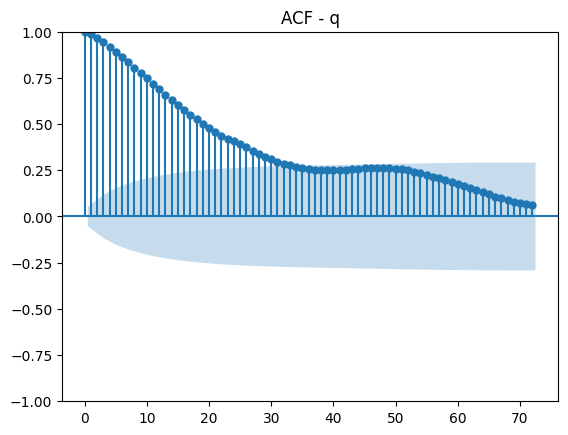

<Figure size 1200x500 with 0 Axes>

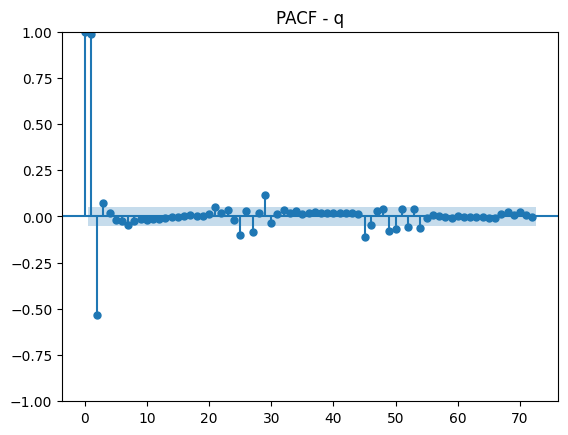

/tmp/ipython-input-228922714.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()


<Figure size 1200x500 with 0 Axes>

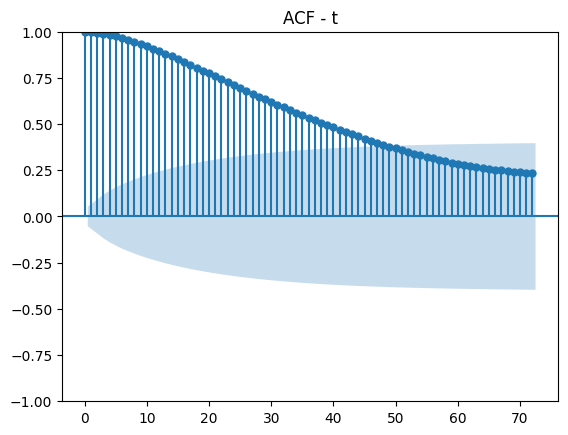

<Figure size 1200x500 with 0 Axes>

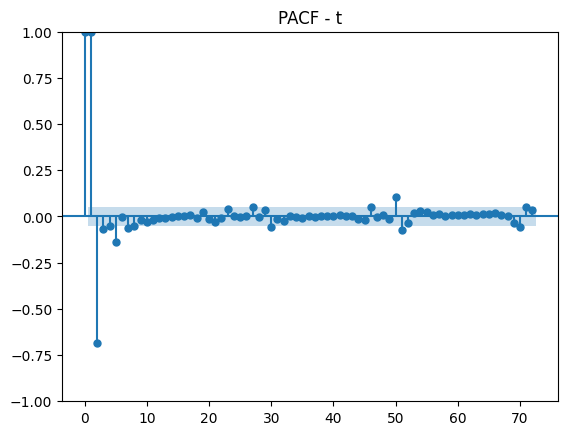

/tmp/ipython-input-228922714.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()


<Figure size 1200x500 with 0 Axes>

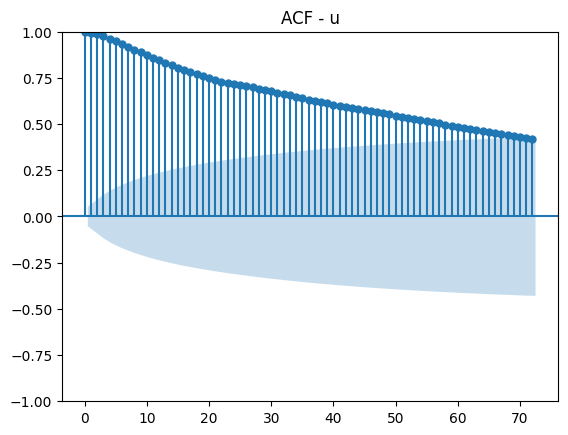

<Figure size 1200x500 with 0 Axes>

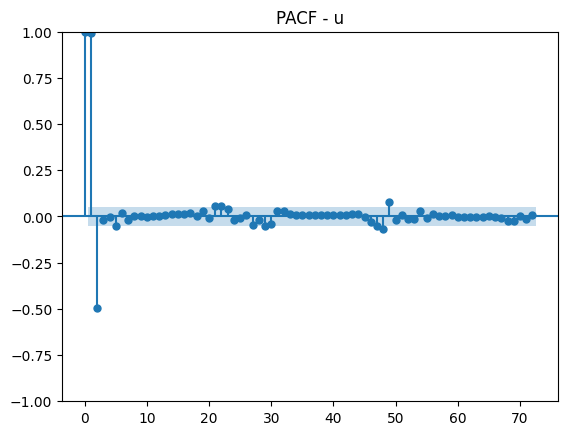

/tmp/ipython-input-228922714.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()


<Figure size 1200x500 with 0 Axes>

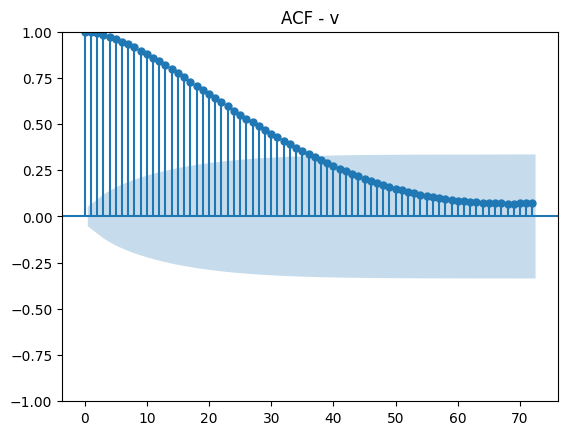

<Figure size 1200x500 with 0 Axes>

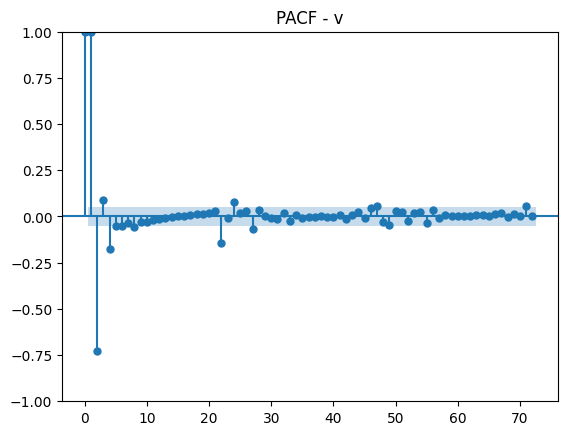

/tmp/ipython-input-228922714.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()


<Figure size 1200x500 with 0 Axes>

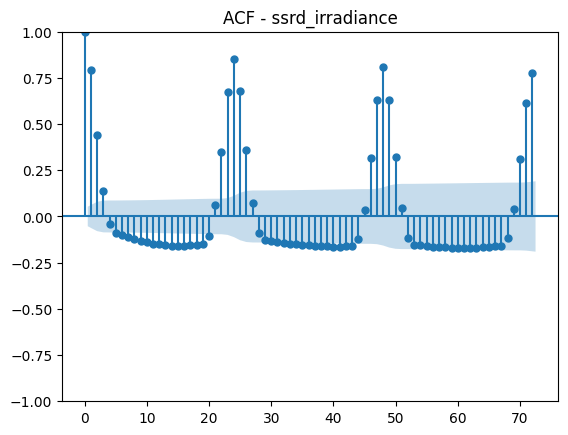

<Figure size 1200x500 with 0 Axes>

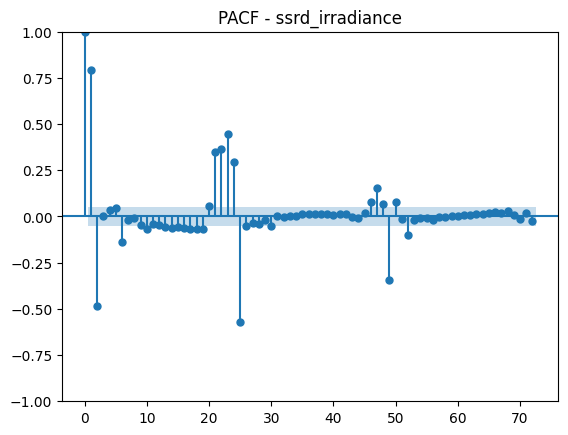

In [ ]:
vars_to_test = ["cc", "q", "t", "u", "v", "ssrd_irradiance"]

for var in vars_to_test:
    series = df_site.set_index("valid_time")[var].asfreq("H").interpolate()

    plt.figure(figsize=(12,5))
    plot_acf(series, lags=72)
    plt.title(f"ACF - {var}")
    plt.show()

    plt.figure(figsize=(12,5))
    plot_pacf(series, lags=72)
    plt.title(f"PACF - {var}")
    plt.show()

Humidity (q): direct influence comes almost entirely from 1-3h; extended memory exists (ACF long decay), but it's indirect

Temperature (t): highly persistent but primarily a diurnal cycle; direct predictive content is short-lag, but indirect diurnal carries structure

Irradiance (ssrd): today's irradiance is highly predictive of tomorrow's irradiance at the same hour (pure diurnal cycle)

Wind components (u, v): direct predictive information mostly short-term, but indirect memory (ACF) is large (12h min, 24 helpful)

ideal window from above (captures daily cycles + slow weather): 24h. Because:
- temp shows strong diurnal
- irradiance is perfectly diurnal
- cloud has a visible 24-hour bump
- wind/humidity respond to slow synoptic cycles

### Corss-correlation over lags

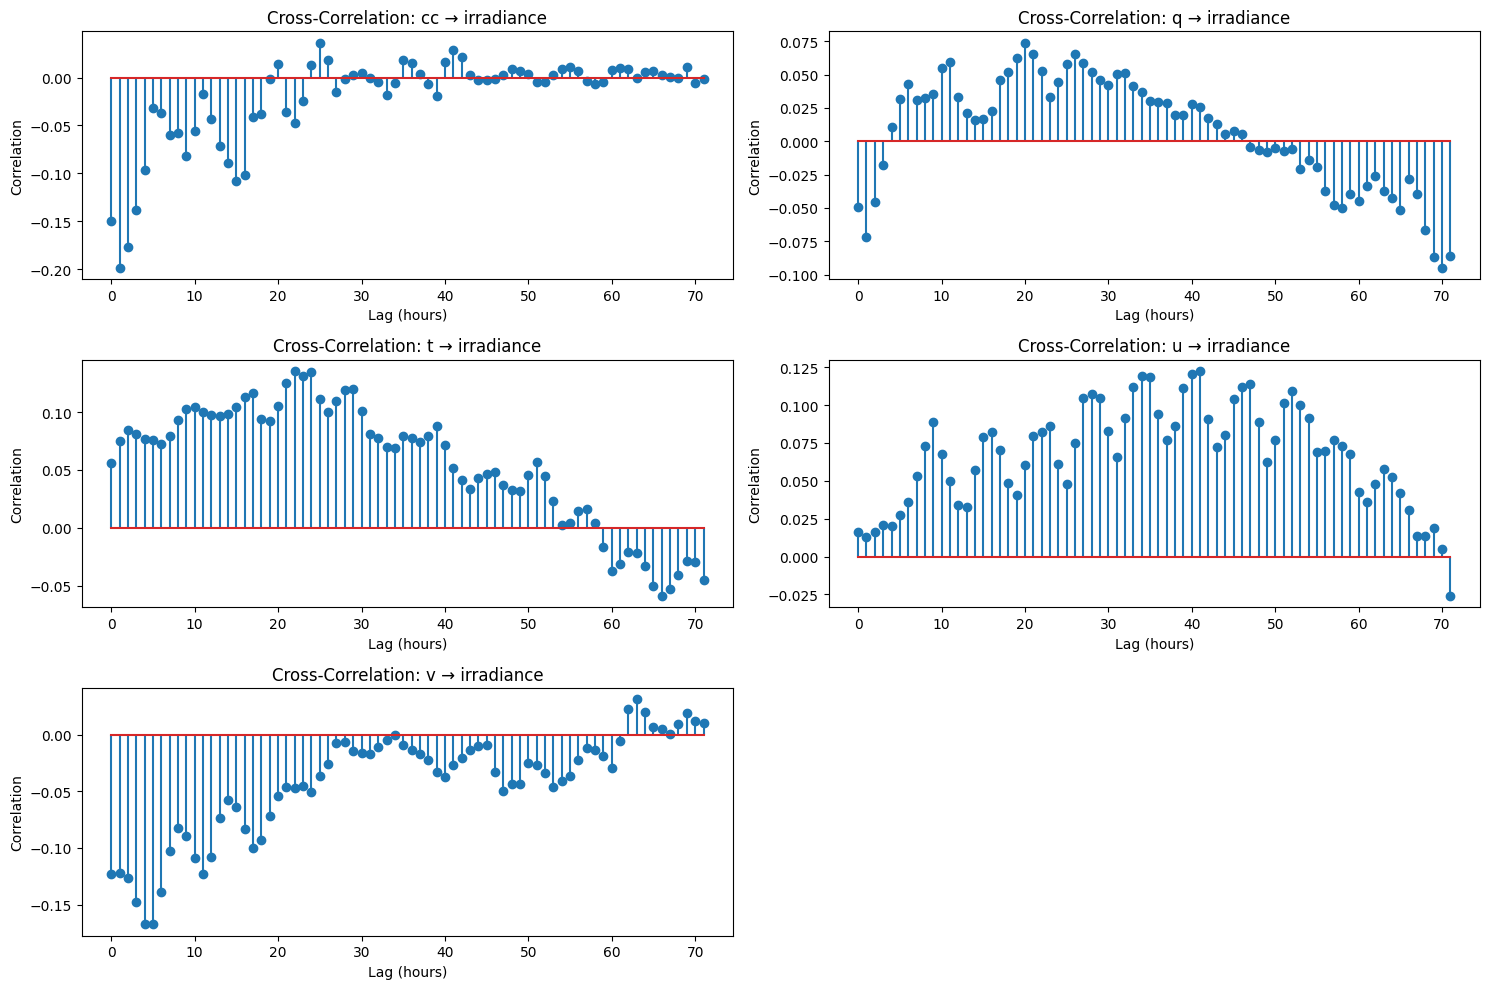

,variable,best_lag,corr_value
0,cc,1,-0.198483
1,q,70,-0.094949
2,t,22,0.135499
3,u,41,0.122531
4,v,4,-0.167623


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# variables to analyze
vars_to_test = ["cc", "q", "t", "u", "v"]

# use irradiance as target (already computed as ssrd_irradiance)
y = df_site.set_index("valid_time")["ssrd_irradiance"]
y = (y - y.mean()) / y.std()     # standardize

max_lag = 72

results = []

plt.figure(figsize=(15, 10))

for i, var in enumerate(vars_to_test, 1):
    x = df_site.set_index("valid_time")[var]

    # standardize for clearer cross-correlation interpretation
    x = (x - x.mean()) / x.std()

    # compute cross-correlation (returns only positive lags)
    corr = ccf(x, y)
    corr = corr[:max_lag]  # truncate

    # find best lag
    best_lag = np.argmax(np.abs(corr))
    best_corr = corr[best_lag]

    results.append({
        "variable": var,
        "best_lag": best_lag,
        "corr_value": best_corr
    })

    # plot
    plt.subplot(3, 2, i)
    plt.stem(range(max_lag), corr)
    plt.title(f"Cross-Correlation: {var} → irradiance")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Correlation")

plt.tight_layout()
plt.show()

# summary table
pd.DataFrame(results)